# Activations to Visualization

This notebook contains code for loading and visualizing activations of an LLM during output generation. The code assumes the generated output is stored in a saved .pt file on your google drive. 


Currently, the model being tested is [Alpaca-LoRA](https://github.com/tloen/alpaca-lora/), 7B parameters

## Description of the saved file

The input prompt, generated output and hidden states are saved as a `.pt` file from pytorch. 

The file is saved as `{input_prompt}.pt`

To load the file use,

`data = torch.load("{input_prompt}.pt", map_location=torch.device('cpu'))`

A peek into what that file looks like when loaded:
```
prompt = data['prompt']
hidden_states = data['hidden_states']
output_sequence = data['sequences'][0]
output = data['output'].split("Response:")[1]
```

The shape of the hidden states will be:

```
hidden states for full output shape: (n_output_tokens, n_layers, num_beams, n_iterations, hidden_size)

n_output_tokens : includes the input tokens, I think even in input each token is fed one at a time
n_layers : 33, number of decoder layers + input layer
num_beams : 1, number of beam searches
n_iterations: n_input_tokens, for first and then 1 for all other output tokens
hidden_size: 4096, based on model config
```

### Mount Google Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!ls '/content/drive/MyDrive/llm'

Mounted at /content/drive
activations  models  test  visualizations


###Import Packages

In [3]:
%pip install -q git+https://github.com/wazeerzulfikar/transformers.git
%pip install umap-learn
%pip install mplcursors
%pip install plotly

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=a456660f95e49e042c5fb583ffb94e2d5fd2d1822e44e792bf1d3ae4c51498a1
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55640 sha256=376

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import torch
from tqdm import tqdm 
import transformers

### Load Activations (.pt file)

In [ ]:
input_prompt = "What_is_4_+_2?"

activation_path = "/content/drive/MyDrive/llm/activations/"+str(input_prompt)+".pt"
data = torch.load(activation_path, map_location=torch.device('cpu'))

# from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
# tokenizer = LlamaTokenizer.from_pretrained('decapoda-research/llama-7b-hf')

###Define Visualization Options & Utility Functions


In [ ]:
def generate_bitmap_animation(data):

  hidden_states = data['hidden_states']
  output_response = data['output'].split("Response:")[1]
  # tokenized_output_response = tokenizer.encode(output_response)

  all_images = []
  vmin=0
  vmax=0

  #iterate through hidden states of all tokens 
  for token_id, token_hidden_states in tqdm(enumerate(hidden_states)):
    # Disregard first hidden state (which inclued all input? tokens)
    if token_id > 0:
      # current_token = tokenized_output_response[token_id]
      current_token_string = output_response[token_id]
      # print("Token ID: "+str(token_id)+"\t Token Value: " + str(current_token), "\t Token String: '" + str(current_token_string)+"'")

      # Initialize an empty dictionary to store activations
      activations = []

      # iterate through all layers for each token's hidden states
      for layer_id, layers in enumerate(token_hidden_states):
        # print("Layer: "+str(layer_id))
        for beam_id, beams in enumerate(layers):
          # print("Beam: "+str(beam_id))
          for token_activation_id, token_activations in enumerate(beams):
            # print(token_activations.shape)
            token_activations_np = token_activations.numpy()  # Detach and convert to NumPy array
            activations.extend(token_activations_np)

      # Determine the size of the square image
      image_size = int(np.ceil(np.sqrt(len(activations))))

      # Create an empty square image with pixel values set to zero
      img = np.zeros((image_size, image_size), dtype=np.uint8)

      # Fill in the image with the normalized activation values
      img.flat[:len(activations)] = activations

      # Add the image to the all_images list
      all_images.append(img)

      # Update the global vmin and vmax
      vmin_token = np.min(activations)
      if vmin_token < vmin:
        vmin = vmin_token
      vmax_token = np.max(activations)
      if vmax_token > vmax:
        vmax = vmax_token

  #Set log norm based on global max and min activations values
  log_norm = LogNorm(vmin=vmin, vmax=vmax)

  # Set the matplotlib backend to save files in the desired format
  matplotlib.use("Agg")

  # Define the update function for the animation
  def update(frame):
      plt.clf()
      plt.imshow(all_images[frame], cmap='viridis', norm=log_norm)
      plt.title(f"Token {frame + 1}: {output_response[frame]}", fontsize=30)
      plt.axis('off')

  # Create the animation
  fig = plt.figure(figsize=(20, 20))
  ani = FuncAnimation(fig, update, frames=len(output_response)-1, interval=250)

  # Save the animation as an MP4 file
  output_file = data["prompt"].replace(' ', '_')+".mp4"
  output_path = "/content/drive/MyDrive/llm/visualizations/"+str(output_file)
  ani.save(output_path, dpi=100, writer="ffmpeg")

  # Set the matplotlib backend back to the default
  matplotlib.use("module://ipykernel.pylab.backend_inline")

  print("visualization succesfully saved: '"+str(output_path)+"'")

def generate_visuals(data, visual_type="bitmap_animation"):
  if visual_type == "bitmap_animation":
    generate_bitmap_animation(data)

###Run Visual Generation & Save Ouput

In [ ]:
generate_visuals(data, visual_type="bitmap_animation")

10it [00:00, 27.98it/s]


visualization succesfully saved: '/content/drive/MyDrive/llm/visualizations/What_is_4_+_2?.mp4'


## UNDER DEVELOPMENT - Visualize Reduced Dim

In [5]:
import os
import pandas as pd
import umap
import matplotlib
from tqdm import tqdm
import seaborn as sns
import re

In [6]:
#Sort the files

import os
import re

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else float('inf')

activation_folder_list = os.listdir("/content/drive/MyDrive/llm/test/")
activation_folder_list = sorted(activation_folder_list, key=extract_number, reverse=True)

# for filename in activation_folder_list:
#     filename_new = '_'.join(filename.split('_')[-3:])
#     # print(filename)


In [7]:


# Array of array 
all_prompt_activations = [] 
all_prompt_filenames = []
# all_token_activations_list = []
max_token_ids= 1

count = 0
for activation_file in tqdm((activation_folder_list), position=0, leave=True): 
  if activation_file.endswith('.pt'):

    if count < 800:
      
      filename = re.sub(r"^Question_\d+_", "", activation_file)

      print(filename)

      all_prompt_filenames.append(filename)

      activation_path = "/content/drive/MyDrive/llm/test/"+str(activation_file)

      data = torch.load(activation_path, map_location=torch.device('cpu'))

      hidden_states = data['hidden_states']
      output_response = data['output'].split("Response:")[1]
      # tokenized_output_response = tokenizer.encode(output_response)

      all_activations = []
      vmin=0
      vmax=0

      #iterate through hidden states of all tokens 
      for token_id, token_hidden_states in tqdm(enumerate(hidden_states)):
        # Disregard first hidden state (which inclued all input? tokens)
        if token_id > 0:
          # current_token = tokenized_output_response[token_id]
          # current_token_string = output_response[token_id]
          # print("Token ID: "+str(token_id)+"\t Token Value: " + str(current_token), "\t Token String: '" + str(current_token_string)+"'")

          # Check if longest token length
          if token_id > max_token_ids :
            max_token_ids = token_id


          # Initialize an empty dictionary to store activations
          activations = []

          # iterate through all layers for each token's hidden states
          for layer_id, layers in enumerate(token_hidden_states):
            # print("Layer: "+str(layer_id))
            for beam_id, beams in enumerate(layers):
              # print("Beam: "+str(beam_id))
              for token_activation_id, token_activations in enumerate(beams):
                # print(token_activations.shape)
                token_activations_np = token_activations.numpy()  # Detach and convert to NumPy array
                activations.extend(token_activations_np)

          # all_activations.append(activations)
          all_activations.append(activations)
      all_prompt_activations.append(all_activations)

      count += 1

# from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
# tokenizer = LlamaTokenizer.from_pretrained('decapoda-research/llama-7b-hf')

  0%|          | 0/1132 [00:00<?, ?it/s]

odd_one_out.pt



8it [00:00, 88.95it/s]
  0%|          | 4/1132 [00:01<05:15,  3.58it/s]

odd_one_out.pt



6it [00:00, 92.63it/s]
  0%|          | 5/1132 [00:02<10:28,  1.79it/s]

odd_one_out.pt



6it [00:00, 102.87it/s]
  1%|          | 6/1132 [00:03<14:18,  1.31it/s]

odd_one_out.pt



6it [00:00, 91.87it/s]
  1%|          | 7/1132 [00:05<17:21,  1.08it/s]

odd_one_out.pt



7it [00:00, 99.41it/s]
  1%|          | 8/1132 [00:06<19:23,  1.04s/it]

odd_one_out.pt



6it [00:00, 101.80it/s]
  1%|          | 9/1132 [00:07<20:45,  1.11s/it]

odd_one_out.pt



6it [00:00, 96.46it/s]
  1%|          | 10/1132 [00:08<21:34,  1.15s/it]

odd_one_out.pt



6it [00:00, 101.96it/s]
  1%|          | 11/1132 [00:10<22:33,  1.21s/it]

odd_one_out.pt



5it [00:00, 102.50it/s]
  1%|          | 12/1132 [00:11<23:01,  1.23s/it]

odd_one_out.pt



6it [00:00, 100.26it/s]
  1%|          | 13/1132 [00:12<23:33,  1.26s/it]

odd_one_out.pt



7it [00:00, 76.04it/s]
  1%|          | 14/1132 [00:14<24:23,  1.31s/it]

odd_one_out.pt



6it [00:00, 98.76it/s]
  1%|▏         | 15/1132 [02:00<10:08:07, 32.67s/it]

odd_one_out.pt



7it [00:00, 93.97it/s]
  1%|▏         | 16/1132 [02:00<7:06:36, 22.94s/it] 

odd_one_out.pt



6it [00:00, 92.21it/s]
  2%|▏         | 17/1132 [02:00<4:59:19, 16.11s/it]

odd_one_out.pt



0it [00:00, ?it/s]
6it [00:00, 49.12it/s]
  2%|▏         | 18/1132 [02:01<3:30:31, 11.34s/it]

odd_one_out.pt



7it [00:00, 97.98it/s]
  2%|▏         | 19/1132 [02:07<3:05:06,  9.98s/it]

odd_one_out.pt



0it [00:00, ?it/s]
8it [00:00, 77.56it/s]
  2%|▏         | 20/1132 [02:08<2:12:32,  7.15s/it]

odd_one_out.pt



6it [00:00, 99.22it/s]
  2%|▏         | 21/1132 [02:09<1:39:37,  5.38s/it]

odd_one_out.pt



6it [00:00, 100.31it/s]
  2%|▏         | 22/1132 [02:09<1:10:44,  3.82s/it]

odd_one_out.pt



7it [00:00, 101.19it/s]
  2%|▏         | 23/1132 [02:11<56:34,  3.06s/it]  

odd_one_out.pt



6it [00:00, 95.32it/s]
  2%|▏         | 24/1132 [02:11<40:15,  2.18s/it]

odd_one_out.pt



7it [00:00, 101.22it/s]
  2%|▏         | 25/1132 [02:11<28:51,  1.56s/it]

odd_one_out.pt



5it [00:00, 100.68it/s]
  2%|▏         | 26/1132 [02:11<20:45,  1.13s/it]

odd_one_out.pt



7it [00:00, 96.90it/s]
  2%|▏         | 27/1132 [02:11<15:15,  1.21it/s]

odd_one_out.pt



6it [00:00, 92.61it/s]
  2%|▏         | 28/1132 [02:11<11:20,  1.62it/s]

odd_one_out.pt



5it [00:00, 107.47it/s]


odd_one_out.pt



6it [00:00, 97.92it/s]
  3%|▎         | 30/1132 [02:12<10:39,  1.72it/s]

odd_one_out.pt



5it [00:00, 95.11it/s]
  3%|▎         | 31/1132 [02:12<08:50,  2.07it/s]

odd_one_out.pt



7it [00:00, 100.68it/s]
  3%|▎         | 32/1132 [02:13<07:10,  2.56it/s]

odd_one_out.pt



6it [00:00, 89.38it/s]
  3%|▎         | 33/1132 [02:13<05:52,  3.12it/s]

month_date_qa.pt



0it [00:00, ?it/s]
10it [00:00, 98.71it/s]
26it [00:00, 82.79it/s]
  3%|▎         | 34/1132 [02:13<06:27,  2.84it/s]

month_date_qa.pt



0it [00:00, ?it/s]
18it [00:00, 83.53it/s]
  3%|▎         | 35/1132 [02:15<12:24,  1.47it/s]

month_date_qa.pt



0it [00:00, ?it/s]
9it [00:00, 89.56it/s]
19it [00:00, 80.21it/s]
  3%|▎         | 36/1132 [02:16<18:00,  1.01it/s]

month_date_qa.pt



0it [00:00, ?it/s]
19it [00:00, 84.65it/s]
  3%|▎         | 37/1132 [02:17<14:27,  1.26it/s]

month_date_qa.pt



9it [00:00, 94.27it/s]
  3%|▎         | 38/1132 [02:17<11:10,  1.63it/s]

month_date_qa.pt



0it [00:00, ?it/s]
9it [00:00, 87.88it/s]
20it [00:00, 78.62it/s]
  3%|▎         | 39/1132 [02:17<10:09,  1.79it/s]

month_date_qa.pt



9it [00:00, 97.34it/s]
  4%|▎         | 40/1132 [02:19<14:34,  1.25it/s]

month_date_qa.pt



0it [00:00, ?it/s]
18it [00:00, 86.79it/s]
  4%|▎         | 41/1132 [02:19<11:47,  1.54it/s]

month_date_qa.pt



8it [00:00, 97.47it/s]
  4%|▎         | 42/1132 [02:19<09:06,  2.00it/s]

month_date_qa.pt



0it [00:00, ?it/s]
9it [00:00, 85.40it/s]
  4%|▍         | 43/1132 [02:21<13:39,  1.33it/s]

month_date_qa.pt



0it [00:00, ?it/s]
10it [00:00, 89.43it/s]
20it [00:00, 82.46it/s]
  4%|▍         | 44/1132 [02:21<11:47,  1.54it/s]

month_date_qa.pt



0it [00:00, ?it/s]
19it [00:00, 83.28it/s]
  4%|▍         | 45/1132 [02:21<10:03,  1.80it/s]

month_date_qa.pt



9it [00:00, 95.17it/s]
  4%|▍         | 46/1132 [02:21<07:57,  2.27it/s]

month_date_qa.pt



0it [00:00, ?it/s]
19it [00:00, 87.58it/s]
  4%|▍         | 47/1132 [02:23<13:46,  1.31it/s]

month_date_qa.pt



8it [00:00, 95.39it/s]
  4%|▍         | 48/1132 [02:23<10:30,  1.72it/s]

month_date_qa.pt



7it [00:00, 89.70it/s]
  4%|▍         | 49/1132 [02:23<08:08,  2.22it/s]

month_date_qa.pt



9it [00:00, 90.97it/s]
  4%|▍         | 50/1132 [02:23<06:33,  2.75it/s]

month_date_qa.pt



0it [00:00, ?it/s]
19it [00:00, 83.86it/s]
  5%|▍         | 51/1132 [02:24<06:36,  2.73it/s]

month_date_qa.pt



0it [00:00, ?it/s]
18it [00:00, 84.29it/s]
  5%|▍         | 52/1132 [02:24<06:19,  2.85it/s]

month_date_qa.pt



0it [00:00, ?it/s]
19it [00:00, 81.51it/s]
  5%|▍         | 53/1132 [02:26<16:08,  1.11it/s]

month_date_qa.pt



0it [00:00, ?it/s]
16it [00:00, 83.17it/s]
  5%|▍         | 54/1132 [02:27<12:49,  1.40it/s]

month_date_qa.pt



0it [00:00, ?it/s]
18it [00:00, 83.44it/s]
  5%|▍         | 55/1132 [02:27<10:42,  1.68it/s]

month_date_qa.pt



9it [00:00, 94.88it/s]
  5%|▍         | 56/1132 [02:27<08:28,  2.12it/s]

month_qa.pt



6it [00:00, 99.01it/s]
  5%|▌         | 57/1132 [02:27<07:01,  2.55it/s]

month_qa.pt



6it [00:00, 95.81it/s]
  5%|▌         | 58/1132 [02:29<12:10,  1.47it/s]

month_qa.pt



5it [00:00, 94.11it/s]
  5%|▌         | 59/1132 [02:29<09:07,  1.96it/s]

month_qa.pt



6it [00:00, 96.13it/s]
  5%|▌         | 60/1132 [02:29<06:59,  2.55it/s]

month_qa.pt



5it [00:00, 104.70it/s]
  5%|▌         | 61/1132 [02:31<14:43,  1.21it/s]

month_qa.pt



5it [00:00, 105.36it/s]
  5%|▌         | 62/1132 [02:32<16:51,  1.06it/s]

month_qa.pt



4it [00:00, 107.06it/s]
  6%|▌         | 63/1132 [02:33<18:43,  1.05s/it]

month_qa.pt



6it [00:00, 96.47it/s]
  6%|▌         | 64/1132 [02:33<13:41,  1.30it/s]

month_qa.pt



5it [00:00, 94.92it/s]


month_qa.pt



7it [00:00, 93.71it/s]
  6%|▌         | 66/1132 [02:34<08:16,  2.15it/s]

month_qa.pt



6it [00:00, 102.75it/s]
  6%|▌         | 67/1132 [02:34<06:42,  2.65it/s]

month_qa.pt



5it [00:00, 96.57it/s]
  6%|▌         | 68/1132 [02:34<05:24,  3.28it/s]

month_qa.pt



7it [00:00, 92.21it/s]
  6%|▌         | 69/1132 [02:35<10:17,  1.72it/s]

month_qa.pt



6it [00:00, 100.57it/s]
  6%|▌         | 70/1132 [02:35<07:57,  2.22it/s]

month_qa.pt



6it [00:00, 101.10it/s]
  6%|▋         | 71/1132 [02:35<06:13,  2.84it/s]

month_qa.pt



6it [00:00, 93.71it/s]
  6%|▋         | 72/1132 [02:35<05:02,  3.50it/s]

month_qa.pt



6it [00:00, 90.48it/s]
  6%|▋         | 73/1132 [02:37<09:58,  1.77it/s]

month_qa.pt



5it [00:00, 104.47it/s]


month_qa.pt



5it [00:00, 95.51it/s]
  7%|▋         | 75/1132 [02:37<06:11,  2.85it/s]

month_qa.pt



5it [00:00, 98.30it/s]
  7%|▋         | 76/1132 [02:39<14:10,  1.24it/s]

month_qa.pt



4it [00:00, 109.43it/s]


month_qa.pt



6it [00:00, 87.50it/s]
  7%|▋         | 78/1132 [02:39<09:00,  1.95it/s]

month_qa.pt



6it [00:00, 94.64it/s]
  7%|▋         | 79/1132 [02:39<07:24,  2.37it/s]

month_qa.pt



6it [00:00, 98.98it/s]
  7%|▋         | 80/1132 [02:40<06:24,  2.73it/s]

month_qa.pt



6it [00:00, 94.61it/s]
  7%|▋         | 81/1132 [02:40<05:15,  3.33it/s]

month_qa.pt



6it [00:00, 92.30it/s]
  7%|▋         | 82/1132 [02:40<04:22,  4.00it/s]

month_qa.pt



5it [00:00, 94.65it/s]
  7%|▋         | 83/1132 [02:40<03:41,  4.74it/s]

month_qa.pt



6it [00:00, 97.74it/s]
  7%|▋         | 84/1132 [02:40<03:10,  5.50it/s]

month_qa.pt



5it [00:00, 93.12it/s]
  8%|▊         | 85/1132 [02:40<02:47,  6.26it/s]

month_qa.pt



5it [00:00, 95.19it/s]


month_qa.pt



4it [00:00, 98.39it/s]
  8%|▊         | 87/1132 [02:40<02:14,  7.79it/s]

month_qa.pt



6it [00:00, 99.22it/s]
  8%|▊         | 88/1132 [02:40<02:08,  8.15it/s]

month_qa.pt



5it [00:00, 96.03it/s]


month_qa.pt



7it [00:00, 94.84it/s]
  8%|▊         | 90/1132 [02:41<02:03,  8.43it/s]

month_qa.pt



6it [00:00, 93.14it/s]
  8%|▊         | 91/1132 [02:41<02:02,  8.50it/s]

month_qa.pt



5it [00:00, 103.59it/s]
  8%|▊         | 92/1132 [02:41<02:19,  7.45it/s]

month_qa.pt



7it [00:00, 91.85it/s]
  8%|▊         | 93/1132 [02:41<02:17,  7.55it/s]

month_qa.pt



6it [00:00, 94.01it/s]
  8%|▊         | 94/1132 [02:42<07:43,  2.24it/s]

month_qa.pt



6it [00:00, 91.56it/s]
  8%|▊         | 95/1132 [02:42<06:08,  2.81it/s]

month_qa.pt



6it [00:00, 93.87it/s]
  8%|▊         | 96/1132 [02:43<04:57,  3.48it/s]

month_qa.pt



6it [00:00, 99.08it/s]
  9%|▊         | 97/1132 [02:43<04:04,  4.23it/s]

month_qa.pt



5it [00:00, 94.51it/s]
  9%|▊         | 98/1132 [02:43<03:23,  5.07it/s]

month_qa.pt



5it [00:00, 88.43it/s]
  9%|▊         | 99/1132 [02:44<08:46,  1.96it/s]

month_qa.pt



5it [00:00, 99.01it/s]
  9%|▉         | 100/1132 [02:44<06:41,  2.57it/s]

month_qa.pt



4it [00:00, 102.52it/s]
  9%|▉         | 101/1132 [02:45<11:04,  1.55it/s]

month_qa.pt



6it [00:00, 89.05it/s]
  9%|▉         | 102/1132 [02:46<08:20,  2.06it/s]

month_qa.pt



6it [00:00, 95.07it/s]
  9%|▉         | 103/1132 [02:46<06:25,  2.67it/s]

month_qa.pt



6it [00:00, 94.93it/s]
  9%|▉         | 104/1132 [02:46<05:30,  3.11it/s]

date_qa.pt



7it [00:00, 92.25it/s]
  9%|▉         | 105/1132 [02:46<04:30,  3.80it/s]

date_qa.pt



7it [00:00, 92.00it/s]
  9%|▉         | 106/1132 [02:46<03:49,  4.47it/s]

date_qa.pt



7it [00:00, 84.33it/s]
  9%|▉         | 107/1132 [02:46<03:24,  5.01it/s]

date_qa.pt



6it [00:00, 92.61it/s]
 10%|▉         | 108/1132 [02:46<02:58,  5.73it/s]

date_qa.pt



6it [00:00, 87.49it/s]
 10%|▉         | 109/1132 [02:46<02:44,  6.23it/s]

date_qa.pt



6it [00:00, 94.34it/s]
 10%|▉         | 110/1132 [02:47<02:29,  6.84it/s]

date_qa.pt



7it [00:00, 88.44it/s]
 10%|▉         | 111/1132 [02:47<02:24,  7.05it/s]

date_qa.pt



7it [00:00, 94.29it/s]
 10%|▉         | 112/1132 [02:47<02:40,  6.36it/s]

date_qa.pt



7it [00:00, 95.24it/s]
 10%|▉         | 113/1132 [02:47<02:31,  6.74it/s]

date_qa.pt



7it [00:00, 85.68it/s]
 10%|█         | 114/1132 [02:47<02:26,  6.93it/s]

date_qa.pt



6it [00:00, 93.02it/s]
 10%|█         | 115/1132 [02:47<02:18,  7.33it/s]

date_qa.pt



6it [00:00, 86.81it/s]
 10%|█         | 116/1132 [02:47<02:13,  7.63it/s]

date_qa.pt



7it [00:00, 93.15it/s]
 10%|█         | 117/1132 [02:48<02:12,  7.64it/s]

date_qa.pt



7it [00:00, 85.55it/s]
 10%|█         | 118/1132 [02:48<02:16,  7.41it/s]

date_qa.pt



5it [00:00, 95.22it/s]
 11%|█         | 119/1132 [02:48<02:06,  8.02it/s]

date_qa.pt



7it [00:00, 91.37it/s]
 11%|█         | 120/1132 [02:48<02:29,  6.77it/s]

date_qa.pt



7it [00:00, 88.48it/s]
 11%|█         | 121/1132 [02:48<02:24,  6.98it/s]

date_qa.pt



7it [00:00, 93.65it/s]
 11%|█         | 122/1132 [02:48<02:20,  7.21it/s]

date_qa.pt



6it [00:00, 92.17it/s]
 11%|█         | 123/1132 [02:48<02:12,  7.59it/s]

date_qa.pt



7it [00:00, 90.64it/s]
 11%|█         | 124/1132 [02:48<02:11,  7.66it/s]

date_qa.pt



6it [00:00, 89.00it/s]
 11%|█         | 125/1132 [02:49<02:07,  7.92it/s]

date_qa.pt



7it [00:00, 91.37it/s]
 11%|█         | 126/1132 [02:49<02:09,  7.78it/s]

date_qa.pt



6it [00:00, 89.18it/s]
 11%|█         | 127/1132 [02:49<02:05,  8.00it/s]

date_qa.pt



6it [00:00, 94.30it/s]
 11%|█▏        | 128/1132 [02:49<02:22,  7.03it/s]

date_qa.pt



7it [00:00, 94.61it/s]
 11%|█▏        | 129/1132 [02:51<12:31,  1.33it/s]

date_qa.pt



7it [00:00, 86.08it/s]
 11%|█▏        | 130/1132 [02:51<09:25,  1.77it/s]

date_qa.pt



8it [00:00, 88.99it/s]
 12%|█▏        | 131/1132 [02:51<07:18,  2.28it/s]

date_qa.pt



7it [00:00, 85.94it/s]
 12%|█▏        | 132/1132 [02:52<05:47,  2.88it/s]

mathematical_operation.pt



6it [00:00, 90.95it/s]
 12%|█▏        | 133/1132 [02:52<04:38,  3.59it/s]

mathematical_operation.pt



8it [00:00, 80.18it/s]
 12%|█▏        | 134/1132 [02:52<04:00,  4.15it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
9it [00:00, 84.81it/s]
 12%|█▏        | 135/1132 [02:52<03:55,  4.23it/s]

mathematical_operation.pt



7it [00:00, 91.84it/s]
 12%|█▏        | 136/1132 [02:52<03:24,  4.88it/s]

mathematical_operation.pt



7it [00:00, 86.92it/s]
 12%|█▏        | 137/1132 [02:52<03:02,  5.46it/s]

mathematical_operation.pt



7it [00:00, 90.26it/s]
 12%|█▏        | 138/1132 [02:53<02:46,  5.99it/s]

mathematical_operation.pt



6it [00:00, 84.59it/s]
 12%|█▏        | 139/1132 [02:53<02:31,  6.53it/s]

mathematical_operation.pt



8it [00:00, 84.47it/s]
 12%|█▏        | 140/1132 [02:54<08:07,  2.03it/s]

mathematical_operation.pt



8it [00:00, 89.20it/s]
 12%|█▏        | 141/1132 [02:55<12:30,  1.32it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
9it [00:00, 71.34it/s]
 13%|█▎        | 142/1132 [02:55<09:41,  1.70it/s]

mathematical_operation.pt



8it [00:00, 84.21it/s]
 13%|█▎        | 143/1132 [02:56<07:32,  2.18it/s]

mathematical_operation.pt



7it [00:00, 92.26it/s]
 13%|█▎        | 144/1132 [02:56<05:57,  2.77it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
9it [00:00, 80.29it/s]
 13%|█▎        | 145/1132 [02:56<05:01,  3.28it/s]

mathematical_operation.pt



7it [00:00, 93.64it/s]
 13%|█▎        | 146/1132 [02:56<04:10,  3.93it/s]

mathematical_operation.pt



7it [00:00, 83.85it/s]
 13%|█▎        | 147/1132 [02:56<03:37,  4.52it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
15it [00:00, 79.22it/s]
 13%|█▎        | 148/1132 [02:57<04:09,  3.95it/s]

mathematical_operation.pt



7it [00:00, 92.89it/s]
 13%|█▎        | 149/1132 [02:57<03:36,  4.53it/s]

mathematical_operation.pt



7it [00:00, 84.80it/s]
 13%|█▎        | 150/1132 [02:57<03:11,  5.14it/s]

mathematical_operation.pt



7it [00:00, 88.59it/s]
 13%|█▎        | 151/1132 [02:57<02:52,  5.67it/s]

mathematical_operation.pt



7it [00:00, 84.95it/s]
 13%|█▎        | 152/1132 [02:57<02:41,  6.05it/s]

mathematical_operation.pt



6it [00:00, 92.62it/s]
 14%|█▎        | 153/1132 [02:57<02:43,  5.98it/s]

mathematical_operation.pt



7it [00:00, 89.48it/s]
 14%|█▎        | 154/1132 [02:57<02:34,  6.33it/s]

mathematical_operation.pt



7it [00:00, 91.64it/s]
 14%|█▎        | 155/1132 [02:59<08:08,  2.00it/s]

mathematical_operation.pt



6it [00:00, 95.74it/s]
 14%|█▍        | 156/1132 [02:59<06:14,  2.60it/s]

mathematical_operation.pt



7it [00:00, 88.70it/s]
 14%|█▍        | 157/1132 [02:59<05:00,  3.25it/s]

mathematical_operation.pt



6it [00:00, 93.04it/s]
 14%|█▍        | 158/1132 [02:59<04:03,  4.00it/s]

mathematical_operation.pt



7it [00:00, 88.65it/s]
 14%|█▍        | 159/1132 [02:59<03:28,  4.67it/s]

mathematical_operation.pt



7it [00:00, 91.73it/s]
 14%|█▍        | 160/1132 [02:59<03:04,  5.27it/s]

mathematical_operation.pt



6it [00:00, 91.42it/s]
 14%|█▍        | 161/1132 [03:00<03:02,  5.32it/s]

mathematical_operation.pt



6it [00:00, 92.92it/s]
 14%|█▍        | 162/1132 [03:00<02:40,  6.04it/s]

mathematical_operation.pt



7it [00:00, 91.60it/s]
 14%|█▍        | 163/1132 [03:00<02:29,  6.49it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
16it [00:00, 79.05it/s]
 14%|█▍        | 164/1132 [03:00<03:05,  5.22it/s]

mathematical_operation.pt



6it [00:00, 90.63it/s]
 15%|█▍        | 165/1132 [03:00<02:48,  5.72it/s]

mathematical_operation.pt



6it [00:00, 89.67it/s]
 15%|█▍        | 166/1132 [03:00<02:31,  6.38it/s]

mathematical_operation.pt



0it [00:00, ?it/s]
15it [00:00, 84.56it/s]
 15%|█▍        | 167/1132 [03:02<09:11,  1.75it/s]

mathematical_operation.pt



6it [00:00, 96.48it/s]
 15%|█▍        | 168/1132 [03:02<07:02,  2.28it/s]

mathematical_operation.pt



6it [00:00, 90.49it/s]
 15%|█▍        | 169/1132 [03:03<11:23,  1.41it/s]

mathematical_operation.pt



6it [00:00, 95.86it/s]
 15%|█▌        | 170/1132 [03:03<08:29,  1.89it/s]

mathematical_operation.pt



5it [00:00, 93.29it/s]
 15%|█▌        | 171/1132 [03:03<06:25,  2.49it/s]

mathematical_operation.pt



5it [00:00, 97.59it/s]


character_qa_close.pt



4it [00:00, 97.60it/s]
 15%|█▌        | 173/1132 [03:04<04:08,  3.86it/s]

character_qa_close.pt



4it [00:00, 98.63it/s]


character_qa_close.pt



4it [00:00, 102.09it/s]
 15%|█▌        | 175/1132 [03:04<03:02,  5.24it/s]

character_qa_close.pt



4it [00:00, 96.26it/s]


character_qa_close.pt



4it [00:00, 96.92it/s]
 16%|█▌        | 177/1132 [03:04<02:27,  6.46it/s]

character_qa_close.pt



5it [00:00, 97.79it/s]


character_qa_close.pt



4it [00:00, 100.17it/s]
 16%|█▌        | 179/1132 [03:04<02:22,  6.71it/s]

character_qa_close.pt



4it [00:00, 104.80it/s]


character_qa_close.pt



4it [00:00, 94.18it/s]
 16%|█▌        | 181/1132 [03:04<02:03,  7.73it/s]

character_qa_close.pt



4it [00:00, 99.81it/s]


character_qa_close.pt



4it [00:00, 99.66it/s]
 16%|█▌        | 183/1132 [03:05<01:49,  8.69it/s]

character_qa_close.pt



5it [00:00, 93.34it/s]


character_qa_close.pt



5it [00:00, 98.20it/s]
 16%|█▋        | 185/1132 [03:05<01:44,  9.08it/s]

character_qa_close.pt



5it [00:00, 96.15it/s]


character_qa_close.pt



5it [00:00, 97.41it/s]
 17%|█▋        | 187/1132 [03:06<04:34,  3.44it/s]

character_qa_close.pt



5it [00:00, 94.22it/s]


character_qa_close.pt



5it [00:00, 95.05it/s]
 17%|█▋        | 189/1132 [03:06<03:39,  4.29it/s]

character_qa_close.pt



4it [00:00, 100.44it/s]


character_qa_close.pt



4it [00:00, 105.96it/s]
 17%|█▋        | 191/1132 [03:08<05:46,  2.72it/s]

character_qa_close.pt



4it [00:00, 100.46it/s]
 17%|█▋        | 192/1132 [03:08<05:10,  3.02it/s]

character_qa_close.pt



5it [00:00, 95.73it/s]
 17%|█▋        | 193/1132 [03:09<07:59,  1.96it/s]

character_qa_close.pt



5it [00:00, 93.46it/s]
 17%|█▋        | 194/1132 [03:09<06:32,  2.39it/s]

character_qa_close.pt



5it [00:00, 96.85it/s]
 17%|█▋        | 195/1132 [03:11<09:40,  1.61it/s]

character_qa_close.pt



4it [00:00, 98.18it/s]


character_qa_close.pt



5it [00:00, 98.67it/s]
 17%|█▋        | 197/1132 [03:11<06:16,  2.48it/s]

character_qa_close.pt



5it [00:00, 90.26it/s]
 17%|█▋        | 198/1132 [03:11<05:13,  2.98it/s]

character_qa_close.pt



4it [00:00, 100.11it/s]


character_qa_close.pt



4it [00:00, 93.52it/s]
 18%|█▊        | 200/1132 [03:11<03:42,  4.19it/s]

character_qa_close.pt



4it [00:00, 99.50it/s]
 18%|█▊        | 201/1132 [03:12<07:22,  2.11it/s]

character_qa_open.pt



7it [00:00, 89.37it/s]
 18%|█▊        | 202/1132 [03:12<06:03,  2.56it/s]

character_qa_open.pt



5it [00:00, 91.67it/s]
 18%|█▊        | 203/1132 [03:13<05:09,  3.00it/s]

character_qa_open.pt



5it [00:00, 97.03it/s]
 18%|█▊        | 204/1132 [03:13<04:11,  3.68it/s]

character_qa_open.pt



6it [00:00, 92.03it/s]
 18%|█▊        | 205/1132 [03:13<03:30,  4.39it/s]

character_qa_open.pt



5it [00:00, 94.42it/s]
 18%|█▊        | 206/1132 [03:13<02:59,  5.16it/s]

character_qa_open.pt



6it [00:00, 94.01it/s]
 18%|█▊        | 207/1132 [03:14<07:54,  1.95it/s]

character_qa_open.pt



6it [00:00, 93.45it/s]
 18%|█▊        | 208/1132 [03:14<06:07,  2.51it/s]

character_qa_open.pt



7it [00:00, 91.92it/s]
 18%|█▊        | 209/1132 [03:16<10:15,  1.50it/s]

character_qa_open.pt



5it [00:00, 99.61it/s]
 19%|█▊        | 210/1132 [03:16<07:40,  2.00it/s]

character_qa_open.pt



5it [00:00, 95.17it/s]
 19%|█▊        | 211/1132 [03:16<05:51,  2.62it/s]

character_qa_open.pt



5it [00:00, 96.91it/s]
 19%|█▊        | 212/1132 [03:18<12:44,  1.20it/s]

character_qa_open.pt



5it [00:00, 98.54it/s]


character_qa_open.pt



6it [00:00, 93.62it/s]
 19%|█▉        | 214/1132 [03:18<07:54,  1.93it/s]

character_qa_open.pt



7it [00:00, 91.88it/s]
 19%|█▉        | 215/1132 [03:18<06:27,  2.37it/s]

character_qa_open.pt



5it [00:00, 93.13it/s]
 19%|█▉        | 216/1132 [03:18<05:10,  2.95it/s]

character_qa_open.pt



4it [00:00, 100.80it/s]


character_qa_open.pt



6it [00:00, 89.71it/s]
 19%|█▉        | 218/1132 [03:18<03:35,  4.24it/s]

character_qa_open.pt



6it [00:00, 92.22it/s]
 19%|█▉        | 219/1132 [03:20<07:25,  2.05it/s]

character_qa_open.pt



5it [00:00, 94.69it/s]


character_qa_open.pt



6it [00:00, 93.19it/s]
 20%|█▉        | 221/1132 [03:21<08:41,  1.75it/s]

character_qa_open.pt



4it [00:00, 99.09it/s]
 20%|█▉        | 222/1132 [03:22<11:02,  1.37it/s]

character_qa_open.pt



0it [00:00, ?it/s]
10it [00:00, 79.37it/s]
 20%|█▉        | 223/1132 [03:24<13:09,  1.15it/s]

character_qa_open.pt



5it [00:00, 94.95it/s]
 20%|█▉        | 224/1132 [03:24<10:12,  1.48it/s]

character_qa_open.pt



7it [00:00, 87.91it/s]
 20%|█▉        | 225/1132 [03:24<08:23,  1.80it/s]

character_qa_open.pt



0it [00:00, ?it/s]
15it [00:00, 77.79it/s]
 20%|█▉        | 226/1132 [03:26<12:14,  1.23it/s]

character_qa_open.pt



6it [00:00, 93.36it/s]
 20%|██        | 227/1132 [03:26<09:18,  1.62it/s]

character_qa_open.pt



6it [00:00, 88.52it/s]
 20%|██        | 228/1132 [03:26<07:07,  2.11it/s]

character_qa_open.pt



6it [00:00, 92.86it/s]
 20%|██        | 229/1132 [03:27<10:57,  1.37it/s]

character_qa_open.pt



4it [00:00, 103.38it/s]
 20%|██        | 230/1132 [03:29<13:50,  1.09it/s]

character_qa_open.pt



0it [00:00, ?it/s]
10it [00:00, 77.81it/s]
 20%|██        | 231/1132 [03:29<10:32,  1.42it/s]

character_qa_open.pt



4it [00:00, 99.15it/s]
 20%|██        | 232/1132 [03:29<08:05,  1.85it/s]

character_qa_close.pt



5it [00:00, 91.02it/s]
 21%|██        | 233/1132 [03:29<06:10,  2.43it/s]

character_qa_close.pt



5it [00:00, 91.09it/s]
 21%|██        | 234/1132 [03:30<10:13,  1.46it/s]

character_qa_close.pt



5it [00:00, 92.54it/s]
 21%|██        | 235/1132 [03:30<07:37,  1.96it/s]

character_qa_close.pt



5it [00:00, 94.21it/s]
 21%|██        | 236/1132 [03:31<05:48,  2.57it/s]

character_qa_close.pt



5it [00:00, 97.11it/s]
 21%|██        | 237/1132 [03:32<09:48,  1.52it/s]

character_qa_close.pt



5it [00:00, 99.37it/s]
 21%|██        | 238/1132 [03:32<07:19,  2.03it/s]

character_qa_close.pt



5it [00:00, 96.41it/s]
 21%|██        | 239/1132 [03:32<05:35,  2.66it/s]

character_qa_close.pt



5it [00:00, 95.67it/s]
 21%|██        | 240/1132 [03:32<04:23,  3.39it/s]

character_qa_close.pt



5it [00:00, 96.21it/s]
 21%|██▏       | 241/1132 [03:32<03:31,  4.21it/s]

character_qa_close.pt



5it [00:00, 99.05it/s]
 21%|██▏       | 242/1132 [03:32<02:55,  5.08it/s]

character_qa_close.pt



5it [00:00, 84.28it/s]
 21%|██▏       | 243/1132 [03:34<07:54,  1.88it/s]

character_qa_close.pt



5it [00:00, 97.49it/s]
 22%|██▏       | 244/1132 [03:34<06:17,  2.35it/s]

character_qa_close.pt



5it [00:00, 98.51it/s]
 22%|██▏       | 245/1132 [03:34<04:50,  3.05it/s]

character_qa_close.pt



5it [00:00, 98.47it/s]
 22%|██▏       | 246/1132 [03:34<03:50,  3.85it/s]

character_qa_close.pt



5it [00:00, 95.11it/s]
 22%|██▏       | 247/1132 [03:34<03:08,  4.69it/s]

character_qa_close.pt



5it [00:00, 97.85it/s]
 22%|██▏       | 248/1132 [03:34<02:40,  5.52it/s]

character_qa_close.pt



5it [00:00, 98.15it/s]
 22%|██▏       | 249/1132 [03:34<02:19,  6.34it/s]

character_qa_close.pt



5it [00:00, 94.18it/s]
 22%|██▏       | 250/1132 [03:34<02:05,  7.05it/s]

character_qa_close.pt



4it [00:00, 99.00it/s]


character_qa_close.pt



5it [00:00, 97.30it/s]
 22%|██▏       | 252/1132 [03:35<01:46,  8.27it/s]

character_qa_close.pt



5it [00:00, 96.23it/s]
 22%|██▏       | 253/1132 [03:35<01:42,  8.57it/s]

character_qa_close.pt



5it [00:00, 91.56it/s]
 22%|██▏       | 254/1132 [03:35<01:39,  8.78it/s]

character_qa_close.pt



5it [00:00, 100.13it/s]
 23%|██▎       | 255/1132 [03:35<01:38,  8.94it/s]

character_qa_close.pt



5it [00:00, 92.34it/s]
 23%|██▎       | 256/1132 [03:35<01:56,  7.52it/s]

character_qa_close.pt



5it [00:00, 93.93it/s]
 23%|██▎       | 257/1132 [03:35<01:49,  7.99it/s]

character_qa_close.pt



5it [00:00, 96.47it/s]
 23%|██▎       | 258/1132 [03:35<01:43,  8.46it/s]

character_qa_close.pt



4it [00:00, 100.74it/s]
 23%|██▎       | 259/1132 [03:37<06:55,  2.10it/s]

character_qa_close.pt



5it [00:00, 99.88it/s]


character_qa_close.pt



4it [00:00, 106.49it/s]
 23%|██▎       | 261/1132 [03:37<04:22,  3.32it/s]

character_qa_open.pt



7it [00:00, 87.70it/s]
 23%|██▎       | 262/1132 [03:37<03:47,  3.83it/s]

character_qa_open.pt



7it [00:00, 80.75it/s]
 23%|██▎       | 263/1132 [03:37<03:22,  4.29it/s]

character_qa_open.pt



6it [00:00, 92.97it/s]
 23%|██▎       | 264/1132 [03:37<02:57,  4.89it/s]

character_qa_open.pt



0it [00:00, ?it/s]
11it [00:00, 76.34it/s]
 23%|██▎       | 265/1132 [03:38<03:00,  4.82it/s]

character_qa_open.pt



6it [00:00, 86.58it/s]
 23%|██▎       | 266/1132 [03:38<02:57,  4.89it/s]

character_qa_open.pt



6it [00:00, 92.20it/s]
 24%|██▎       | 267/1132 [03:38<02:36,  5.52it/s]

character_qa_open.pt



6it [00:00, 86.75it/s]
 24%|██▎       | 268/1132 [03:38<02:21,  6.09it/s]

character_qa_open.pt



7it [00:00, 88.25it/s]
 24%|██▍       | 269/1132 [03:38<02:17,  6.30it/s]

character_qa_open.pt



5it [00:00, 89.65it/s]
 24%|██▍       | 270/1132 [03:38<02:04,  6.92it/s]

character_qa_open.pt



6it [00:00, 83.96it/s]
 24%|██▍       | 271/1132 [03:38<01:59,  7.22it/s]

character_qa_open.pt



5it [00:00, 88.65it/s]
 24%|██▍       | 272/1132 [03:38<01:50,  7.76it/s]

character_qa_open.pt



5it [00:00, 92.63it/s]
 24%|██▍       | 273/1132 [03:39<01:43,  8.27it/s]

character_qa_open.pt



7it [00:00, 89.33it/s]
 24%|██▍       | 274/1132 [03:39<01:46,  8.05it/s]

character_qa_open.pt



7it [00:00, 88.83it/s]
 24%|██▍       | 275/1132 [03:39<02:11,  6.54it/s]

character_qa_open.pt



8it [00:00, 92.81it/s]
 24%|██▍       | 276/1132 [03:39<02:08,  6.66it/s]

character_qa_open.pt



5it [00:00, 86.91it/s]
 24%|██▍       | 277/1132 [03:39<01:59,  7.17it/s]

character_qa_open.pt



7it [00:00, 90.19it/s]
 25%|██▍       | 278/1132 [03:39<02:00,  7.08it/s]

character_qa_open.pt



7it [00:00, 85.50it/s]
 25%|██▍       | 279/1132 [03:41<07:21,  1.93it/s]

character_qa_open.pt



4it [00:00, 90.38it/s]
 25%|██▍       | 280/1132 [03:41<05:34,  2.55it/s]

character_qa_open.pt



6it [00:00, 92.78it/s]
 25%|██▍       | 281/1132 [03:41<04:22,  3.24it/s]

character_qa_open.pt



5it [00:00, 89.65it/s]
 25%|██▍       | 282/1132 [03:41<03:32,  4.00it/s]

character_qa_open.pt



6it [00:00, 92.92it/s]
 25%|██▌       | 283/1132 [03:41<02:58,  4.76it/s]

character_qa_open.pt



6it [00:00, 84.44it/s]
 25%|██▌       | 284/1132 [03:43<07:58,  1.77it/s]

character_qa_open.pt



7it [00:00, 85.28it/s]
 25%|██▌       | 285/1132 [03:43<06:09,  2.29it/s]

character_qa_open.pt



7it [00:00, 86.05it/s]
 25%|██▌       | 286/1132 [03:43<04:57,  2.85it/s]

character_qa_open.pt



7it [00:00, 93.66it/s]
 25%|██▌       | 287/1132 [03:43<04:01,  3.50it/s]

character_qa_open.pt



7it [00:00, 87.47it/s]
 25%|██▌       | 288/1132 [03:43<03:23,  4.15it/s]

character_qa_open.pt



5it [00:00, 98.75it/s]
 26%|██▌       | 289/1132 [03:43<02:49,  4.97it/s]

character_qa_open.pt



4it [00:00, 101.70it/s]


character_qa_open.pt



7it [00:00, 88.99it/s]
 26%|██▌       | 291/1132 [03:44<02:27,  5.69it/s]

character_qa_open.pt



7it [00:00, 90.14it/s]
 26%|██▌       | 292/1132 [03:44<02:20,  5.98it/s]

character_qa_close.pt



5it [00:00, 94.55it/s]
 26%|██▌       | 293/1132 [03:44<02:10,  6.43it/s]

character_qa_close.pt



5it [00:00, 95.51it/s]
 26%|██▌       | 294/1132 [03:44<01:59,  7.00it/s]

character_qa_close.pt



5it [00:00, 89.35it/s]
 26%|██▌       | 295/1132 [03:44<01:56,  7.20it/s]

character_qa_close.pt



5it [00:00, 93.16it/s]
 26%|██▌       | 296/1132 [03:44<01:49,  7.63it/s]

character_qa_close.pt



5it [00:00, 96.40it/s]
 26%|██▌       | 297/1132 [03:45<06:39,  2.09it/s]

character_qa_close.pt



5it [00:00, 93.56it/s]
 26%|██▋       | 298/1132 [03:46<05:35,  2.49it/s]

character_qa_close.pt



5it [00:00, 95.72it/s]
 26%|██▋       | 299/1132 [03:46<04:23,  3.16it/s]

character_qa_close.pt



5it [00:00, 99.84it/s]
 27%|██▋       | 300/1132 [03:46<03:30,  3.95it/s]

character_qa_close.pt



5it [00:00, 85.48it/s]
 27%|██▋       | 301/1132 [03:46<02:57,  4.68it/s]

character_qa_close.pt



5it [00:00, 97.97it/s]
 27%|██▋       | 302/1132 [03:47<07:41,  1.80it/s]

character_qa_close.pt



5it [00:00, 94.99it/s]
 27%|██▋       | 303/1132 [03:47<05:52,  2.35it/s]

character_qa_close.pt



5it [00:00, 96.06it/s]
 27%|██▋       | 304/1132 [03:48<04:37,  2.98it/s]

character_qa_close.pt



5it [00:00, 95.10it/s]
 27%|██▋       | 305/1132 [03:49<09:10,  1.50it/s]

character_qa_close.pt



5it [00:00, 89.76it/s]
 27%|██▋       | 306/1132 [03:49<06:56,  1.98it/s]

character_qa_close.pt



5it [00:00, 93.93it/s]
 27%|██▋       | 307/1132 [03:49<05:20,  2.57it/s]

character_qa_close.pt



5it [00:00, 100.27it/s]
 27%|██▋       | 308/1132 [03:49<04:10,  3.29it/s]

character_qa_close.pt



5it [00:00, 94.67it/s]
 27%|██▋       | 309/1132 [03:51<08:13,  1.67it/s]

character_qa_close.pt



5it [00:00, 89.10it/s]
 27%|██▋       | 310/1132 [03:51<06:13,  2.20it/s]

character_qa_close.pt



5it [00:00, 83.15it/s]
 27%|██▋       | 311/1132 [03:51<04:53,  2.80it/s]

character_qa_close.pt



5it [00:00, 90.14it/s]
 28%|██▊       | 312/1132 [03:51<03:55,  3.48it/s]

character_qa_close.pt



5it [00:00, 85.25it/s]
 28%|██▊       | 313/1132 [03:51<03:17,  4.15it/s]

character_qa_close.pt



5it [00:00, 95.34it/s]
 28%|██▊       | 314/1132 [03:51<03:03,  4.47it/s]

character_qa_close.pt



5it [00:00, 91.57it/s]
 28%|██▊       | 315/1132 [03:51<02:35,  5.26it/s]

character_qa_close.pt



5it [00:00, 95.67it/s]
 28%|██▊       | 316/1132 [03:52<02:17,  5.92it/s]

character_qa_close.pt



5it [00:00, 95.35it/s]
 28%|██▊       | 317/1132 [03:53<07:05,  1.91it/s]

character_qa_close.pt



5it [00:00, 83.63it/s]
 28%|██▊       | 318/1132 [03:53<05:26,  2.49it/s]

character_qa_close.pt



5it [00:00, 97.43it/s]
 28%|██▊       | 319/1132 [03:53<04:16,  3.17it/s]

character_qa_close.pt



5it [00:00, 86.08it/s]
 28%|██▊       | 320/1132 [03:53<03:33,  3.80it/s]

character_qa_close.pt



4it [00:00, 101.09it/s]


character_qa_open.pt



5it [00:00, 97.40it/s]
 28%|██▊       | 322/1132 [03:54<02:31,  5.35it/s]

character_qa_open.pt



6it [00:00, 87.21it/s]
 29%|██▊       | 323/1132 [03:54<02:19,  5.80it/s]

character_qa_open.pt



8it [00:00, 79.32it/s]
 29%|██▊       | 324/1132 [03:54<02:17,  5.87it/s]

character_qa_open.pt



5it [00:00, 97.92it/s]
 29%|██▊       | 325/1132 [03:55<06:32,  2.06it/s]

character_qa_open.pt



6it [00:00, 93.01it/s]
 29%|██▉       | 326/1132 [03:56<09:29,  1.42it/s]

character_qa_open.pt



5it [00:00, 91.58it/s]
 29%|██▉       | 327/1132 [03:57<07:11,  1.87it/s]

character_qa_open.pt



6it [00:00, 92.52it/s]
 29%|██▉       | 328/1132 [03:57<05:34,  2.40it/s]

character_qa_open.pt



6it [00:00, 88.96it/s]
 29%|██▉       | 329/1132 [03:57<04:24,  3.04it/s]

character_qa_open.pt



6it [00:00, 93.94it/s]
 29%|██▉       | 330/1132 [03:57<03:36,  3.71it/s]

character_qa_open.pt



6it [00:00, 87.14it/s]
 29%|██▉       | 331/1132 [03:57<03:03,  4.36it/s]

character_qa_open.pt



5it [00:00, 87.98it/s]
 29%|██▉       | 332/1132 [03:58<07:06,  1.87it/s]

character_qa_open.pt



8it [00:00, 84.94it/s]
 29%|██▉       | 333/1132 [03:58<05:36,  2.37it/s]

character_qa_open.pt



6it [00:00, 90.94it/s]
 30%|██▉       | 334/1132 [03:59<04:27,  2.98it/s]

character_qa_open.pt



7it [00:00, 90.25it/s]
 30%|██▉       | 335/1132 [03:59<04:04,  3.26it/s]

character_qa_open.pt



6it [00:00, 88.81it/s]
 30%|██▉       | 336/1132 [03:59<03:26,  3.85it/s]

character_qa_open.pt



0it [00:00, ?it/s]
10it [00:00, 85.04it/s]
 30%|██▉       | 337/1132 [04:00<07:47,  1.70it/s]

character_qa_open.pt



8it [00:00, 88.81it/s]
 30%|██▉       | 338/1132 [04:00<06:05,  2.17it/s]

character_qa_open.pt



6it [00:00, 93.27it/s]
 30%|██▉       | 339/1132 [04:01<04:47,  2.76it/s]

character_qa_open.pt



4it [00:00, 99.66it/s]


character_qa_open.pt



4it [00:00, 104.35it/s]
 30%|███       | 341/1132 [04:03<09:02,  1.46it/s]

character_qa_open.pt



6it [00:00, 89.22it/s]
 30%|███       | 342/1132 [04:03<07:14,  1.82it/s]

character_qa_open.pt



0it [00:00, ?it/s]
14it [00:00, 77.28it/s]
 30%|███       | 343/1132 [04:03<06:29,  2.03it/s]

character_qa_open.pt



6it [00:00, 84.44it/s]
 30%|███       | 344/1132 [04:03<05:15,  2.50it/s]

character_qa_open.pt



7it [00:00, 89.54it/s]
 30%|███       | 345/1132 [04:04<04:20,  3.02it/s]

character_qa_open.pt



7it [00:00, 90.34it/s]
 31%|███       | 346/1132 [04:04<03:42,  3.53it/s]

character_qa_open.pt



7it [00:00, 77.61it/s]
 31%|███       | 347/1132 [04:04<03:14,  4.03it/s]

character_qa_open.pt



7it [00:00, 84.61it/s]
 31%|███       | 348/1132 [04:04<02:50,  4.60it/s]

character_qa_open.pt



5it [00:00, 92.07it/s]
 31%|███       | 349/1132 [04:06<09:35,  1.36it/s]

character_qa_open.pt



4it [00:00, 81.97it/s]
 31%|███       | 350/1132 [04:06<07:16,  1.79it/s]

character_qa_open.pt



6it [00:00, 88.92it/s]
 31%|███       | 351/1132 [04:06<05:40,  2.29it/s]

character_qa_open.pt



5it [00:00, 93.06it/s]
 31%|███       | 352/1132 [04:06<04:47,  2.72it/s]

character_qa_close.pt



5it [00:00, 97.08it/s]
 31%|███       | 353/1132 [04:08<08:28,  1.53it/s]

character_qa_close.pt



5it [00:00, 93.93it/s]
 31%|███▏      | 354/1132 [04:08<06:24,  2.02it/s]

character_qa_close.pt



5it [00:00, 89.76it/s]
 31%|███▏      | 355/1132 [04:08<04:59,  2.60it/s]

character_qa_close.pt



4it [00:00, 98.74it/s]
 31%|███▏      | 356/1132 [04:08<03:52,  3.33it/s]

character_qa_close.pt



4it [00:00, 98.62it/s]
 32%|███▏      | 357/1132 [04:08<03:10,  4.06it/s]

character_qa_close.pt



5it [00:00, 90.57it/s]
 32%|███▏      | 358/1132 [04:10<07:17,  1.77it/s]

character_qa_close.pt



5it [00:00, 95.04it/s]
 32%|███▏      | 359/1132 [04:10<05:32,  2.32it/s]

character_qa_close.pt



5it [00:00, 97.68it/s]
 32%|███▏      | 360/1132 [04:10<04:22,  2.94it/s]

character_qa_close.pt



5it [00:00, 96.25it/s]
 32%|███▏      | 361/1132 [04:10<03:27,  3.72it/s]

character_qa_close.pt



4it [00:00, 92.66it/s]
 32%|███▏      | 362/1132 [04:10<02:51,  4.49it/s]

character_qa_close.pt



4it [00:00, 92.24it/s]
 32%|███▏      | 363/1132 [04:10<02:27,  5.21it/s]

character_qa_close.pt



5it [00:00, 94.92it/s]
 32%|███▏      | 364/1132 [04:10<02:28,  5.19it/s]

character_qa_close.pt



4it [00:00, 100.01it/s]
 32%|███▏      | 365/1132 [04:12<09:22,  1.36it/s]

character_qa_close.pt



4it [00:00, 99.67it/s]


character_qa_close.pt



4it [00:00, 98.37it/s]
 32%|███▏      | 367/1132 [04:13<05:35,  2.28it/s]

character_qa_close.pt



4it [00:00, 101.06it/s]


character_qa_close.pt



4it [00:00, 100.76it/s]
 33%|███▎      | 369/1132 [04:13<03:53,  3.27it/s]

character_qa_close.pt



4it [00:00, 103.23it/s]


character_qa_close.pt



4it [00:00, 101.14it/s]
 33%|███▎      | 371/1132 [04:13<02:55,  4.34it/s]

character_qa_close.pt



4it [00:00, 103.86it/s]
 33%|███▎      | 372/1132 [04:13<02:34,  4.90it/s]

character_qa_close.pt



4it [00:00, 100.22it/s]


character_qa_close.pt



5it [00:00, 97.66it/s]
 33%|███▎      | 374/1132 [04:13<02:05,  6.03it/s]

character_qa_close.pt



5it [00:00, 93.69it/s]
 33%|███▎      | 375/1132 [04:15<05:06,  2.47it/s]

character_qa_close.pt



5it [00:00, 98.41it/s]
 33%|███▎      | 376/1132 [04:16<07:47,  1.62it/s]

character_qa_close.pt



5it [00:00, 92.81it/s]
 33%|███▎      | 377/1132 [04:16<06:29,  1.94it/s]

character_qa_close.pt



5it [00:00, 89.84it/s]
 33%|███▎      | 378/1132 [04:17<08:55,  1.41it/s]

character_qa_close.pt



4it [00:00, 100.08it/s]
 33%|███▎      | 379/1132 [04:17<06:56,  1.81it/s]

character_qa_close.pt



4it [00:00, 98.19it/s]


character_qa_close.pt



4it [00:00, 80.86it/s]
 34%|███▎      | 381/1132 [04:18<04:27,  2.81it/s]

character_qa_open.pt



7it [00:00, 90.52it/s]
 34%|███▎      | 382/1132 [04:19<07:18,  1.71it/s]

character_qa_open.pt



6it [00:00, 85.21it/s]
 34%|███▍      | 383/1132 [04:19<05:54,  2.11it/s]

character_qa_open.pt



6it [00:00, 94.34it/s]
 34%|███▍      | 384/1132 [04:19<04:48,  2.59it/s]

character_qa_open.pt



0it [00:00, ?it/s]
8it [00:00, 76.30it/s]
 34%|███▍      | 385/1132 [04:19<04:03,  3.07it/s]

character_qa_open.pt



6it [00:00, 85.04it/s]
 34%|███▍      | 386/1132 [04:20<03:26,  3.61it/s]

character_qa_open.pt



6it [00:00, 91.86it/s]
 34%|███▍      | 387/1132 [04:21<07:30,  1.65it/s]

character_qa_open.pt



7it [00:00, 89.09it/s]
 34%|███▍      | 388/1132 [04:21<05:53,  2.11it/s]

character_qa_open.pt



6it [00:00, 93.47it/s]
 34%|███▍      | 389/1132 [04:21<04:42,  2.63it/s]

character_qa_open.pt



6it [00:00, 87.87it/s]
 34%|███▍      | 390/1132 [04:21<03:50,  3.22it/s]

character_qa_open.pt



6it [00:00, 90.09it/s]
 35%|███▍      | 391/1132 [04:22<03:08,  3.93it/s]

character_qa_open.pt



7it [00:00, 85.68it/s]
 35%|███▍      | 392/1132 [04:23<06:54,  1.78it/s]

character_qa_open.pt



6it [00:00, 91.05it/s]
 35%|███▍      | 393/1132 [04:23<05:27,  2.26it/s]

character_qa_open.pt



8it [00:00, 89.59it/s]
 35%|███▍      | 394/1132 [04:23<04:22,  2.81it/s]

character_qa_open.pt



7it [00:00, 90.20it/s]
 35%|███▍      | 395/1132 [04:23<03:50,  3.20it/s]

character_qa_open.pt



6it [00:00, 87.43it/s]
 35%|███▍      | 396/1132 [04:24<03:08,  3.91it/s]

character_qa_open.pt



5it [00:00, 94.87it/s]
 35%|███▌      | 397/1132 [04:24<02:52,  4.26it/s]

character_qa_open.pt



6it [00:00, 94.07it/s]
 35%|███▌      | 398/1132 [04:24<02:33,  4.79it/s]

character_qa_open.pt



6it [00:00, 87.42it/s]
 35%|███▌      | 399/1132 [04:24<02:14,  5.46it/s]

character_qa_open.pt



7it [00:00, 89.13it/s]
 35%|███▌      | 400/1132 [04:24<02:13,  5.50it/s]

character_qa_open.pt



6it [00:00, 95.43it/s]
 35%|███▌      | 401/1132 [04:24<02:04,  5.86it/s]

character_qa_open.pt



6it [00:00, 96.27it/s]
 36%|███▌      | 402/1132 [04:26<08:49,  1.38it/s]

character_qa_open.pt



7it [00:00, 91.00it/s]
 36%|███▌      | 403/1132 [04:26<06:45,  1.80it/s]

character_qa_open.pt



5it [00:00, 94.42it/s]
 36%|███▌      | 404/1132 [04:28<09:19,  1.30it/s]

character_qa_open.pt



7it [00:00, 94.92it/s]
 36%|███▌      | 405/1132 [04:28<07:04,  1.71it/s]

character_qa_open.pt



8it [00:00, 84.42it/s]
 36%|███▌      | 406/1132 [04:28<05:34,  2.17it/s]

character_qa_open.pt



5it [00:00, 91.72it/s]
 36%|███▌      | 407/1132 [04:28<04:40,  2.59it/s]

character_qa_open.pt



5it [00:00, 95.94it/s]
 36%|███▌      | 408/1132 [04:28<03:43,  3.24it/s]

character_qa_open.pt



6it [00:00, 89.62it/s]
 36%|███▌      | 409/1132 [04:29<03:12,  3.76it/s]

character_qa_open.pt



6it [00:00, 90.52it/s]
 36%|███▌      | 410/1132 [04:29<02:44,  4.38it/s]

character_qa_open.pt



5it [00:00, 90.45it/s]
 36%|███▋      | 411/1132 [04:29<02:23,  5.02it/s]

character_qa_open.pt



6it [00:00, 91.85it/s]
 36%|███▋      | 412/1132 [04:29<02:14,  5.37it/s]

character_qa_close.pt



5it [00:00, 95.56it/s]
 36%|███▋      | 413/1132 [04:29<01:59,  6.01it/s]

character_qa_close.pt



4it [00:00, 103.19it/s]
 37%|███▋      | 414/1132 [04:29<01:48,  6.59it/s]

character_qa_close.pt



4it [00:00, 100.38it/s]


character_qa_close.pt



4it [00:00, 92.97it/s]
 37%|███▋      | 416/1132 [04:29<01:32,  7.78it/s]

character_qa_close.pt



4it [00:00, 95.50it/s]
 37%|███▋      | 417/1132 [04:30<01:30,  7.92it/s]

character_qa_close.pt



5it [00:00, 94.29it/s]
 37%|███▋      | 418/1132 [04:30<01:30,  7.92it/s]

character_qa_close.pt



5it [00:00, 89.02it/s]
 37%|███▋      | 419/1132 [04:31<05:27,  2.17it/s]

character_qa_close.pt



5it [00:00, 85.43it/s]
 37%|███▋      | 420/1132 [04:31<04:23,  2.71it/s]

character_qa_close.pt



5it [00:00, 80.90it/s]
 37%|███▋      | 421/1132 [04:31<03:37,  3.27it/s]

character_qa_close.pt



4it [00:00, 102.17it/s]
 37%|███▋      | 422/1132 [04:31<02:56,  4.02it/s]

character_qa_close.pt



4it [00:00, 100.59it/s]
 37%|███▋      | 423/1132 [04:33<06:27,  1.83it/s]

character_qa_close.pt



5it [00:00, 92.45it/s]
 37%|███▋      | 424/1132 [04:33<04:58,  2.37it/s]

character_qa_close.pt



5it [00:00, 85.96it/s]
 38%|███▊      | 425/1132 [04:33<03:59,  2.95it/s]

character_qa_close.pt



5it [00:00, 92.52it/s]
 38%|███▊      | 426/1132 [04:33<03:10,  3.71it/s]

character_qa_close.pt



5it [00:00, 90.72it/s]
 38%|███▊      | 427/1132 [04:34<06:40,  1.76it/s]

character_qa_close.pt



5it [00:00, 95.05it/s]
 38%|███▊      | 428/1132 [04:36<09:06,  1.29it/s]

character_qa_close.pt



4it [00:00, 100.23it/s]


character_qa_close.pt



5it [00:00, 91.96it/s]
 38%|███▊      | 430/1132 [04:36<05:28,  2.14it/s]

character_qa_close.pt



5it [00:00, 92.56it/s]
 38%|███▊      | 431/1132 [04:36<04:29,  2.60it/s]

character_qa_close.pt



5it [00:00, 96.85it/s]
 38%|███▊      | 432/1132 [04:36<03:55,  2.98it/s]

character_qa_close.pt



5it [00:00, 92.53it/s]
 38%|███▊      | 433/1132 [04:37<06:52,  1.70it/s]

character_qa_close.pt



5it [00:00, 92.32it/s]
 38%|███▊      | 434/1132 [04:38<05:19,  2.19it/s]

character_qa_close.pt



5it [00:00, 84.01it/s]
 38%|███▊      | 435/1132 [04:38<04:16,  2.72it/s]

character_qa_close.pt



5it [00:00, 97.43it/s]
 39%|███▊      | 436/1132 [04:38<03:31,  3.28it/s]

character_qa_close.pt



5it [00:00, 89.26it/s]
 39%|███▊      | 437/1132 [04:38<02:54,  3.98it/s]

character_qa_close.pt



5it [00:00, 99.04it/s]
 39%|███▊      | 438/1132 [04:38<02:28,  4.66it/s]

character_qa_close.pt



4it [00:00, 99.01it/s]
 39%|███▉      | 439/1132 [04:38<02:05,  5.52it/s]

character_qa_close.pt



4it [00:00, 101.08it/s]
 39%|███▉      | 440/1132 [04:38<01:49,  6.30it/s]

character_qa_close.pt



4it [00:00, 99.21it/s]
 39%|███▉      | 441/1132 [04:38<01:44,  6.61it/s]

character_qa_open.pt



6it [00:00, 92.62it/s]
 39%|███▉      | 442/1132 [04:39<01:47,  6.40it/s]

character_qa_open.pt



5it [00:00, 101.04it/s]
 39%|███▉      | 443/1132 [04:39<01:36,  7.17it/s]

character_qa_open.pt



5it [00:00, 84.43it/s]
 39%|███▉      | 444/1132 [04:39<01:36,  7.10it/s]

character_qa_open.pt



0it [00:00, ?it/s]
17it [00:00, 79.10it/s]
 39%|███▉      | 445/1132 [04:39<02:25,  4.71it/s]

character_qa_open.pt



6it [00:00, 89.76it/s]
 39%|███▉      | 446/1132 [04:39<02:13,  5.13it/s]

character_qa_open.pt



6it [00:00, 88.87it/s]
 39%|███▉      | 447/1132 [04:40<02:03,  5.54it/s]

character_qa_open.pt



7it [00:00, 91.23it/s]
 40%|███▉      | 448/1132 [04:40<01:58,  5.78it/s]

character_qa_open.pt



6it [00:00, 84.20it/s]
 40%|███▉      | 449/1132 [04:40<01:55,  5.92it/s]

character_qa_open.pt



6it [00:00, 86.02it/s]
 40%|███▉      | 450/1132 [04:40<01:53,  6.02it/s]

character_qa_open.pt



0it [00:00, ?it/s]
9it [00:00, 86.92it/s]
 40%|███▉      | 451/1132 [04:40<01:58,  5.74it/s]

character_qa_open.pt



5it [00:00, 99.19it/s]
 40%|███▉      | 452/1132 [04:40<02:04,  5.47it/s]

character_qa_open.pt



6it [00:00, 90.94it/s]
 40%|████      | 453/1132 [04:41<01:59,  5.70it/s]

character_qa_open.pt



0it [00:00, ?it/s]
17it [00:00, 78.73it/s]
 40%|████      | 454/1132 [04:41<02:26,  4.64it/s]

character_qa_open.pt



5it [00:00, 86.22it/s]
 40%|████      | 455/1132 [04:41<02:14,  5.05it/s]

character_qa_open.pt



7it [00:00, 87.65it/s]
 40%|████      | 456/1132 [04:41<02:06,  5.35it/s]

character_qa_open.pt



5it [00:00, 96.67it/s]
 40%|████      | 457/1132 [04:43<06:01,  1.87it/s]

character_qa_open.pt



6it [00:00, 82.84it/s]
 40%|████      | 458/1132 [04:43<04:48,  2.34it/s]

character_qa_open.pt



6it [00:00, 83.34it/s]
 41%|████      | 459/1132 [04:43<04:07,  2.72it/s]

character_qa_open.pt



7it [00:00, 87.41it/s]
 41%|████      | 460/1132 [04:43<03:26,  3.26it/s]

character_qa_open.pt



6it [00:00, 94.09it/s]
 41%|████      | 461/1132 [04:43<02:49,  3.95it/s]

character_qa_open.pt



6it [00:00, 94.17it/s]
 41%|████      | 462/1132 [04:43<02:24,  4.63it/s]

character_qa_open.pt



8it [00:00, 88.98it/s]
 41%|████      | 463/1132 [04:44<02:14,  4.97it/s]

character_qa_open.pt



5it [00:00, 85.22it/s]
 41%|████      | 464/1132 [04:45<05:52,  1.89it/s]

character_qa_open.pt



8it [00:00, 87.89it/s]
 41%|████      | 465/1132 [04:45<04:40,  2.38it/s]

character_qa_open.pt



8it [00:00, 88.97it/s]
 41%|████      | 466/1132 [04:45<03:50,  2.89it/s]

character_qa_open.pt



5it [00:00, 92.64it/s]
 41%|████▏     | 467/1132 [04:47<07:11,  1.54it/s]

character_qa_open.pt



5it [00:00, 91.67it/s]
 41%|████▏     | 468/1132 [04:47<05:25,  2.04it/s]

character_qa_open.pt



5it [00:00, 95.54it/s]
 41%|████▏     | 469/1132 [04:47<04:14,  2.60it/s]

character_qa_open.pt



4it [00:00, 93.79it/s]
 42%|████▏     | 470/1132 [04:47<03:22,  3.28it/s]

character_qa_open.pt



7it [00:00, 90.74it/s]
 42%|████▏     | 471/1132 [04:47<02:46,  3.96it/s]

character_qa_open.pt



5it [00:00, 94.34it/s]
 42%|████▏     | 472/1132 [04:47<02:18,  4.77it/s]

character_qa_close.pt



5it [00:00, 93.44it/s]
 42%|████▏     | 473/1132 [04:47<02:05,  5.27it/s]

character_qa_close.pt



5it [00:00, 97.53it/s]
 42%|████▏     | 474/1132 [04:49<06:02,  1.81it/s]

character_qa_close.pt



5it [00:00, 92.67it/s]
 42%|████▏     | 475/1132 [04:49<04:42,  2.32it/s]

character_qa_close.pt



5it [00:00, 95.56it/s]
 42%|████▏     | 476/1132 [04:49<03:47,  2.88it/s]

character_qa_close.pt



5it [00:00, 92.82it/s]
 42%|████▏     | 477/1132 [04:49<03:04,  3.56it/s]

character_qa_close.pt



5it [00:00, 95.61it/s]
 42%|████▏     | 478/1132 [04:49<02:49,  3.86it/s]

character_qa_close.pt



5it [00:00, 96.79it/s]
 42%|████▏     | 479/1132 [04:49<02:26,  4.47it/s]

character_qa_close.pt



5it [00:00, 94.12it/s]
 42%|████▏     | 480/1132 [04:50<02:08,  5.08it/s]

character_qa_close.pt



5it [00:00, 95.36it/s]
 42%|████▏     | 481/1132 [04:51<05:55,  1.83it/s]

character_qa_close.pt



5it [00:00, 87.01it/s]
 43%|████▎     | 482/1132 [04:52<08:21,  1.30it/s]

character_qa_close.pt



5it [00:00, 97.59it/s]
 43%|████▎     | 483/1132 [04:52<06:15,  1.73it/s]

character_qa_close.pt



5it [00:00, 85.97it/s]
 43%|████▎     | 484/1132 [04:53<04:48,  2.25it/s]

character_qa_close.pt



5it [00:00, 95.57it/s]
 43%|████▎     | 485/1132 [04:53<03:51,  2.80it/s]

character_qa_close.pt



5it [00:00, 94.60it/s]
 43%|████▎     | 486/1132 [04:54<07:03,  1.53it/s]

character_qa_close.pt



5it [00:00, 92.05it/s]
 43%|████▎     | 487/1132 [04:54<05:21,  2.00it/s]

character_qa_close.pt



5it [00:00, 94.81it/s]
 43%|████▎     | 488/1132 [04:54<04:08,  2.59it/s]

character_qa_close.pt



5it [00:00, 77.88it/s]
 43%|████▎     | 489/1132 [04:56<07:10,  1.49it/s]

character_qa_close.pt



5it [00:00, 87.09it/s]
 43%|████▎     | 490/1132 [04:57<09:42,  1.10it/s]

character_qa_close.pt



5it [00:00, 92.84it/s]
 43%|████▎     | 491/1132 [04:57<07:12,  1.48it/s]

character_qa_close.pt



5it [00:00, 93.90it/s]
 43%|████▎     | 492/1132 [04:57<05:32,  1.93it/s]

character_qa_close.pt



5it [00:00, 87.95it/s]
 44%|████▎     | 493/1132 [04:57<04:21,  2.45it/s]

character_qa_close.pt



5it [00:00, 92.69it/s]
 44%|████▎     | 494/1132 [04:58<03:27,  3.08it/s]

character_qa_close.pt



5it [00:00, 87.73it/s]
 44%|████▎     | 495/1132 [04:58<02:50,  3.74it/s]

character_qa_close.pt



5it [00:00, 91.57it/s]
 44%|████▍     | 496/1132 [04:58<02:27,  4.30it/s]

character_qa_close.pt



5it [00:00, 97.93it/s]
 44%|████▍     | 497/1132 [04:58<02:10,  4.88it/s]

character_qa_close.pt



5it [00:00, 94.28it/s]
 44%|████▍     | 498/1132 [04:58<01:56,  5.42it/s]

character_qa_close.pt



5it [00:00, 96.11it/s]
 44%|████▍     | 499/1132 [04:58<01:51,  5.66it/s]

character_qa_close.pt



5it [00:00, 97.11it/s]
 44%|████▍     | 500/1132 [04:58<01:41,  6.21it/s]

character_qa_close.pt



5it [00:00, 94.24it/s]
 44%|████▍     | 501/1132 [04:59<01:34,  6.68it/s]

character_qa_open.pt



7it [00:00, 80.12it/s]
 44%|████▍     | 502/1132 [04:59<01:51,  5.65it/s]

character_qa_open.pt



0it [00:00, ?it/s]
13it [00:00, 81.69it/s]
 44%|████▍     | 503/1132 [04:59<02:07,  4.92it/s]

character_qa_open.pt



6it [00:00, 92.52it/s]
 45%|████▍     | 504/1132 [04:59<02:01,  5.16it/s]

character_qa_open.pt



0it [00:00, ?it/s]
13it [00:00, 83.58it/s]
 45%|████▍     | 505/1132 [05:01<05:52,  1.78it/s]

character_qa_open.pt



6it [00:00, 95.84it/s]
 45%|████▍     | 506/1132 [05:01<04:37,  2.25it/s]

character_qa_open.pt



6it [00:00, 92.14it/s]
 45%|████▍     | 507/1132 [05:03<09:41,  1.08it/s]

character_qa_open.pt



6it [00:00, 84.09it/s]
 45%|████▍     | 508/1132 [05:03<07:17,  1.42it/s]

character_qa_open.pt



7it [00:00, 87.55it/s]
 45%|████▍     | 509/1132 [05:05<09:47,  1.06it/s]

character_qa_open.pt



6it [00:00, 89.58it/s]
 45%|████▌     | 510/1132 [05:06<10:47,  1.04s/it]

character_qa_open.pt



6it [00:00, 86.19it/s]
 45%|████▌     | 511/1132 [05:06<07:57,  1.30it/s]

character_qa_open.pt



0it [00:00, ?it/s]
14it [00:00, 80.24it/s]
 45%|████▌     | 512/1132 [05:06<06:21,  1.62it/s]

character_qa_open.pt



6it [00:00, 91.92it/s]
 45%|████▌     | 513/1132 [05:08<08:29,  1.22it/s]

character_qa_open.pt



7it [00:00, 87.65it/s]
 45%|████▌     | 514/1132 [05:08<06:29,  1.59it/s]

character_qa_open.pt



6it [00:00, 92.83it/s]
 45%|████▌     | 515/1132 [05:08<05:01,  2.04it/s]

character_qa_open.pt



7it [00:00, 78.90it/s]
 46%|████▌     | 516/1132 [05:08<04:03,  2.53it/s]

character_qa_open.pt



5it [00:00, 87.81it/s]
 46%|████▌     | 517/1132 [05:08<03:19,  3.09it/s]

character_qa_open.pt



0it [00:00, ?it/s]
9it [00:00, 77.03it/s]
18it [00:00, 71.57it/s]
 46%|████▌     | 518/1132 [05:09<03:41,  2.78it/s]

character_qa_open.pt



8it [00:00, 81.67it/s]
 46%|████▌     | 519/1132 [05:10<06:47,  1.50it/s]

character_qa_open.pt



6it [00:00, 91.56it/s]
 46%|████▌     | 520/1132 [05:10<05:13,  1.95it/s]

character_qa_open.pt



6it [00:00, 81.58it/s]
 46%|████▌     | 521/1132 [05:10<04:24,  2.31it/s]

character_qa_open.pt



5it [00:00, 97.14it/s]
 46%|████▌     | 522/1132 [05:11<03:28,  2.92it/s]

character_qa_open.pt



6it [00:00, 91.62it/s]
 46%|████▌     | 523/1132 [05:12<06:43,  1.51it/s]

character_qa_open.pt



8it [00:00, 88.64it/s]
 46%|████▋     | 524/1132 [05:12<05:36,  1.81it/s]

character_qa_open.pt



8it [00:00, 89.88it/s]
 46%|████▋     | 525/1132 [05:12<04:29,  2.26it/s]

character_qa_open.pt



0it [00:00, ?it/s]
9it [00:00, 88.48it/s]
18it [00:00, 78.65it/s]
26it [00:00, 77.43it/s]
 46%|████▋     | 526/1132 [05:13<04:38,  2.17it/s]

character_qa_open.pt



7it [00:00, 86.50it/s]
 47%|████▋     | 527/1132 [05:13<04:06,  2.45it/s]

character_qa_open.pt



7it [00:00, 84.71it/s]
 47%|████▋     | 528/1132 [05:13<03:23,  2.96it/s]

character_qa_open.pt



5it [00:00, 91.03it/s]
 47%|████▋     | 529/1132 [05:15<06:28,  1.55it/s]

character_qa_open.pt



6it [00:00, 93.76it/s]
 47%|████▋     | 530/1132 [05:15<05:00,  2.00it/s]

character_qa_open.pt



6it [00:00, 89.67it/s]
 47%|████▋     | 531/1132 [05:15<03:57,  2.53it/s]

character_qa_open.pt



0it [00:00, ?it/s]
10it [00:00, 83.07it/s]
 47%|████▋     | 532/1132 [05:17<09:20,  1.07it/s]

character_qa_close.pt



4it [00:00, 101.59it/s]
 47%|████▋     | 533/1132 [05:19<10:23,  1.04s/it]

character_qa_close.pt



4it [00:00, 95.80it/s]
 47%|████▋     | 534/1132 [05:19<07:38,  1.30it/s]

character_qa_close.pt



4it [00:00, 87.19it/s]
 47%|████▋     | 535/1132 [05:19<05:44,  1.73it/s]

character_qa_close.pt



4it [00:00, 99.18it/s]
 47%|████▋     | 536/1132 [05:19<04:25,  2.24it/s]

character_qa_close.pt



4it [00:00, 99.65it/s]
 47%|████▋     | 537/1132 [05:19<03:28,  2.85it/s]

character_qa_close.pt



4it [00:00, 94.64it/s]
 48%|████▊     | 538/1132 [05:20<06:26,  1.54it/s]

character_qa_close.pt



4it [00:00, 97.66it/s]
 48%|████▊     | 539/1132 [05:22<08:13,  1.20it/s]

character_qa_close.pt



4it [00:00, 99.26it/s]
 48%|████▊     | 540/1132 [05:22<06:07,  1.61it/s]

character_qa_close.pt



4it [00:00, 91.41it/s]
 48%|████▊     | 541/1132 [05:22<04:40,  2.11it/s]

character_qa_close.pt



4it [00:00, 91.21it/s]
 48%|████▊     | 542/1132 [05:23<07:09,  1.37it/s]

character_qa_close.pt



4it [00:00, 102.01it/s]


character_qa_close.pt



4it [00:00, 100.30it/s]
 48%|████▊     | 544/1132 [05:24<04:21,  2.25it/s]

character_qa_close.pt



5it [00:00, 92.45it/s]
 48%|████▊     | 545/1132 [05:24<03:37,  2.70it/s]

character_qa_close.pt



5it [00:00, 94.99it/s]
 48%|████▊     | 546/1132 [05:24<03:04,  3.18it/s]

character_qa_close.pt



5it [00:00, 90.70it/s]
 48%|████▊     | 547/1132 [05:24<02:38,  3.69it/s]

character_qa_close.pt



5it [00:00, 90.89it/s]
 48%|████▊     | 548/1132 [05:25<05:33,  1.75it/s]

character_qa_close.pt



4it [00:00, 91.35it/s]


character_qa_close.pt



4it [00:00, 98.57it/s]
 49%|████▊     | 550/1132 [05:27<05:54,  1.64it/s]

character_qa_close.pt



4it [00:00, 95.15it/s]
 49%|████▊     | 551/1132 [05:27<04:45,  2.03it/s]

character_qa_close.pt



4it [00:00, 99.23it/s]
 49%|████▉     | 552/1132 [05:28<07:09,  1.35it/s]

character_qa_close.pt



4it [00:00, 99.95it/s]
 49%|████▉     | 553/1132 [05:28<05:36,  1.72it/s]

character_qa_close.pt



5it [00:00, 100.20it/s]
 49%|████▉     | 554/1132 [05:29<04:27,  2.16it/s]

character_qa_close.pt



4it [00:00, 105.07it/s]
 49%|████▉     | 555/1132 [05:29<03:30,  2.74it/s]

character_qa_close.pt



4it [00:00, 98.54it/s]
 49%|████▉     | 556/1132 [05:29<02:47,  3.44it/s]

character_qa_close.pt



5it [00:00, 94.85it/s]
 49%|████▉     | 557/1132 [05:29<02:19,  4.11it/s]

character_qa_close.pt



4it [00:00, 95.77it/s]
 49%|████▉     | 558/1132 [05:29<02:04,  4.63it/s]

character_qa_close.pt



4it [00:00, 104.56it/s]
 49%|████▉     | 559/1132 [05:30<05:18,  1.80it/s]

character_qa_close.pt



4it [00:00, 88.20it/s]
 49%|████▉     | 560/1132 [05:31<04:09,  2.30it/s]

character_qa_close.pt



4it [00:00, 103.66it/s]
 50%|████▉     | 561/1132 [05:31<03:13,  2.94it/s]

character_qa_open.pt



6it [00:00, 93.41it/s]
 50%|████▉     | 562/1132 [05:31<02:44,  3.47it/s]

character_qa_open.pt



6it [00:00, 91.35it/s]
 50%|████▉     | 563/1132 [05:31<02:27,  3.86it/s]

character_qa_open.pt



6it [00:00, 92.40it/s]
 50%|████▉     | 564/1132 [05:31<02:12,  4.30it/s]

character_qa_open.pt



7it [00:00, 86.16it/s]
 50%|████▉     | 565/1132 [05:31<02:15,  4.18it/s]

character_qa_open.pt



6it [00:00, 92.14it/s]
 50%|█████     | 566/1132 [05:37<16:28,  1.75s/it]

character_qa_open.pt



6it [00:00, 74.31it/s]
 50%|█████     | 567/1132 [05:37<12:02,  1.28s/it]

character_qa_open.pt



6it [00:00, 84.08it/s]
 50%|█████     | 568/1132 [05:37<08:52,  1.06it/s]

character_qa_open.pt



6it [00:00, 89.89it/s]
 50%|█████     | 569/1132 [05:37<06:40,  1.41it/s]

character_qa_open.pt



6it [00:00, 90.37it/s]
 50%|█████     | 570/1132 [05:37<05:10,  1.81it/s]

character_qa_open.pt



5it [00:00, 88.39it/s]
 50%|█████     | 571/1132 [05:38<04:04,  2.29it/s]

character_qa_open.pt



5it [00:00, 84.82it/s]
 51%|█████     | 572/1132 [05:38<03:18,  2.82it/s]

character_qa_open.pt



6it [00:00, 82.05it/s]
 51%|█████     | 573/1132 [05:38<02:43,  3.41it/s]

character_qa_open.pt



7it [00:00, 90.69it/s]
 51%|█████     | 574/1132 [05:38<02:26,  3.81it/s]

character_qa_open.pt



7it [00:00, 92.58it/s]
 51%|█████     | 575/1132 [05:38<02:12,  4.21it/s]

character_qa_open.pt



6it [00:00, 90.30it/s]
 51%|█████     | 576/1132 [05:39<02:10,  4.25it/s]

character_qa_open.pt



4it [00:00, 85.92it/s]
 51%|█████     | 577/1132 [05:39<02:42,  3.42it/s]

character_qa_open.pt



5it [00:00, 87.61it/s]
 51%|█████     | 578/1132 [05:39<02:19,  3.98it/s]

character_qa_open.pt



6it [00:00, 90.39it/s]
 51%|█████     | 579/1132 [05:39<02:04,  4.42it/s]

character_qa_open.pt



4it [00:00, 88.99it/s]


character_qa_open.pt



5it [00:00, 95.07it/s]
 51%|█████▏    | 581/1132 [05:40<01:40,  5.50it/s]

character_qa_open.pt



6it [00:00, 90.03it/s]
 51%|█████▏    | 582/1132 [05:40<01:41,  5.44it/s]

character_qa_open.pt



8it [00:00, 90.47it/s]
 52%|█████▏    | 583/1132 [05:40<01:39,  5.54it/s]

character_qa_open.pt



6it [00:00, 94.16it/s]
 52%|█████▏    | 584/1132 [05:41<03:10,  2.87it/s]

character_qa_open.pt



7it [00:00, 90.80it/s]
 52%|█████▏    | 585/1132 [05:41<02:46,  3.28it/s]

character_qa_open.pt



7it [00:00, 90.60it/s]
 52%|█████▏    | 586/1132 [05:42<05:46,  1.58it/s]

character_qa_open.pt



6it [00:00, 90.68it/s]
 52%|█████▏    | 587/1132 [05:43<04:34,  1.98it/s]

character_qa_open.pt



6it [00:00, 94.73it/s]
 52%|█████▏    | 588/1132 [05:43<03:41,  2.46it/s]

character_qa_open.pt



5it [00:00, 93.87it/s]
 52%|█████▏    | 589/1132 [05:43<02:59,  3.02it/s]

character_qa_open.pt



4it [00:00, 99.28it/s]
 52%|█████▏    | 590/1132 [05:44<05:33,  1.63it/s]

character_qa_open.pt



5it [00:00, 94.67it/s]
 52%|█████▏    | 591/1132 [05:44<04:19,  2.08it/s]

character_qa_open.pt



6it [00:00, 86.33it/s]
 52%|█████▏    | 592/1132 [05:46<06:28,  1.39it/s]

character_qa_close.pt



4it [00:00, 100.27it/s]
 52%|█████▏    | 593/1132 [05:46<04:56,  1.82it/s]

character_qa_close.pt



4it [00:00, 98.66it/s]
 52%|█████▏    | 594/1132 [05:48<08:47,  1.02it/s]

character_qa_close.pt



4it [00:00, 99.49it/s]
 53%|█████▎    | 595/1132 [05:48<06:34,  1.36it/s]

character_qa_close.pt



4it [00:00, 100.99it/s]
 53%|█████▎    | 596/1132 [05:48<05:02,  1.77it/s]

character_qa_close.pt



4it [00:00, 95.71it/s]
 53%|█████▎    | 597/1132 [05:49<06:55,  1.29it/s]

character_qa_close.pt



5it [00:00, 96.07it/s]
 53%|█████▎    | 598/1132 [05:50<05:35,  1.59it/s]

character_qa_close.pt



5it [00:00, 90.05it/s]
 53%|█████▎    | 599/1132 [05:50<04:28,  1.98it/s]

character_qa_close.pt



5it [00:00, 88.86it/s]
 53%|█████▎    | 600/1132 [05:51<06:32,  1.36it/s]

character_qa_close.pt



5it [00:00, 83.07it/s]
 53%|█████▎    | 601/1132 [05:51<04:52,  1.82it/s]

character_qa_close.pt



4it [00:00, 100.35it/s]
 53%|█████▎    | 602/1132 [05:51<03:49,  2.31it/s]

character_qa_close.pt



4it [00:00, 103.03it/s]
 53%|█████▎    | 603/1132 [05:53<06:14,  1.41it/s]

character_qa_close.pt



5it [00:00, 88.68it/s]
 53%|█████▎    | 604/1132 [05:53<04:49,  1.82it/s]

character_qa_close.pt



5it [00:00, 80.64it/s]
 53%|█████▎    | 605/1132 [05:54<07:02,  1.25it/s]

character_qa_close.pt



5it [00:00, 88.07it/s]
 54%|█████▎    | 606/1132 [05:54<05:20,  1.64it/s]

character_qa_close.pt



5it [00:00, 96.56it/s]
 54%|█████▎    | 607/1132 [05:55<04:00,  2.18it/s]

character_qa_close.pt



5it [00:00, 95.36it/s]
 54%|█████▎    | 608/1132 [05:56<06:12,  1.41it/s]

character_qa_close.pt



5it [00:00, 97.84it/s]
 54%|█████▍    | 609/1132 [05:56<04:46,  1.83it/s]

character_qa_close.pt



4it [00:00, 101.44it/s]


character_qa_close.pt



5it [00:00, 86.05it/s]
 54%|█████▍    | 611/1132 [05:56<03:10,  2.73it/s]

character_qa_close.pt



5it [00:00, 96.86it/s]
 54%|█████▍    | 612/1132 [05:58<05:14,  1.65it/s]

character_qa_close.pt



5it [00:00, 94.25it/s]
 54%|█████▍    | 613/1132 [05:58<04:14,  2.04it/s]

character_qa_close.pt



5it [00:00, 94.73it/s]
 54%|█████▍    | 614/1132 [05:58<04:09,  2.07it/s]

character_qa_close.pt



5it [00:00, 96.65it/s]
 54%|█████▍    | 615/1132 [06:00<06:16,  1.37it/s]

character_qa_close.pt



5it [00:00, 97.84it/s]
 54%|█████▍    | 616/1132 [06:01<07:36,  1.13it/s]

character_qa_close.pt



5it [00:00, 90.00it/s]
 55%|█████▍    | 617/1132 [06:01<05:50,  1.47it/s]

character_qa_close.pt



5it [00:00, 88.16it/s]
 55%|█████▍    | 618/1132 [06:01<04:35,  1.86it/s]

character_qa_close.pt



4it [00:00, 101.78it/s]
 55%|█████▍    | 619/1132 [06:01<03:34,  2.39it/s]

character_qa_close.pt



5it [00:00, 94.14it/s]
 55%|█████▍    | 620/1132 [06:02<02:50,  3.00it/s]

character_qa_close.pt



4it [00:00, 86.61it/s]
 55%|█████▍    | 621/1132 [06:02<02:25,  3.52it/s]

character_qa_open.pt



7it [00:00, 90.11it/s]
 55%|█████▍    | 622/1132 [06:02<02:10,  3.92it/s]

character_qa_open.pt



5it [00:00, 94.05it/s]
 55%|█████▌    | 623/1132 [06:02<02:04,  4.09it/s]

character_qa_open.pt



6it [00:00, 93.07it/s]
 55%|█████▌    | 624/1132 [06:02<01:53,  4.49it/s]

character_qa_open.pt



7it [00:00, 89.22it/s]
 55%|█████▌    | 625/1132 [06:02<01:47,  4.73it/s]

character_qa_open.pt



6it [00:00, 79.38it/s]
 55%|█████▌    | 626/1132 [06:03<02:04,  4.06it/s]

character_qa_open.pt



6it [00:00, 83.25it/s]
 55%|█████▌    | 627/1132 [06:03<01:54,  4.42it/s]

character_qa_open.pt



6it [00:00, 93.14it/s]
 55%|█████▌    | 628/1132 [06:04<04:51,  1.73it/s]

character_qa_open.pt



6it [00:00, 92.27it/s]
 56%|█████▌    | 629/1132 [06:06<06:41,  1.25it/s]

character_qa_open.pt



7it [00:00, 86.32it/s]
 56%|█████▌    | 630/1132 [06:06<05:14,  1.60it/s]

character_qa_open.pt



6it [00:00, 84.49it/s]
 56%|█████▌    | 631/1132 [06:06<04:04,  2.05it/s]

character_qa_open.pt



5it [00:00, 93.20it/s]
 56%|█████▌    | 632/1132 [06:06<03:13,  2.59it/s]

character_qa_open.pt



6it [00:00, 86.18it/s]
 56%|█████▌    | 633/1132 [06:06<02:41,  3.10it/s]

character_qa_open.pt



7it [00:00, 86.67it/s]
 56%|█████▌    | 634/1132 [06:07<02:20,  3.55it/s]

character_qa_open.pt



6it [00:00, 92.08it/s]
 56%|█████▌    | 635/1132 [06:07<02:22,  3.48it/s]

character_qa_open.pt



7it [00:00, 87.81it/s]
 56%|█████▌    | 636/1132 [06:08<04:57,  1.67it/s]

character_qa_open.pt



5it [00:00, 95.32it/s]
 56%|█████▋    | 637/1132 [06:08<03:50,  2.15it/s]

character_qa_open.pt



6it [00:00, 88.45it/s]
 56%|█████▋    | 638/1132 [06:09<03:04,  2.68it/s]

character_qa_open.pt



6it [00:00, 88.03it/s]
 56%|█████▋    | 639/1132 [06:09<02:27,  3.35it/s]

character_qa_open.pt



5it [00:00, 94.22it/s]
 57%|█████▋    | 640/1132 [06:10<05:01,  1.63it/s]

character_qa_open.pt



6it [00:00, 94.45it/s]
 57%|█████▋    | 641/1132 [06:10<03:53,  2.11it/s]

character_qa_open.pt



5it [00:00, 94.56it/s]
 57%|█████▋    | 642/1132 [06:11<03:34,  2.28it/s]

character_qa_open.pt



6it [00:00, 93.13it/s]
 57%|█████▋    | 643/1132 [06:11<02:54,  2.81it/s]

character_qa_open.pt



6it [00:00, 79.36it/s]
 57%|█████▋    | 644/1132 [06:11<02:21,  3.46it/s]

character_qa_open.pt



7it [00:00, 86.16it/s]
 57%|█████▋    | 645/1132 [06:11<02:15,  3.59it/s]

character_qa_open.pt



7it [00:00, 84.73it/s]
 57%|█████▋    | 646/1132 [06:12<04:42,  1.72it/s]

character_qa_open.pt



7it [00:00, 86.13it/s]
 57%|█████▋    | 647/1132 [06:14<06:40,  1.21it/s]

character_qa_open.pt



7it [00:00, 87.35it/s]
 57%|█████▋    | 648/1132 [06:15<07:50,  1.03it/s]

character_qa_open.pt



5it [00:00, 96.48it/s]
 57%|█████▋    | 649/1132 [06:16<08:36,  1.07s/it]

character_qa_open.pt



4it [00:00, 97.92it/s]


character_qa_open.pt



6it [00:00, 78.28it/s]
 58%|█████▊    | 651/1132 [06:17<05:09,  1.56it/s]

character_qa_open.pt



5it [00:00, 93.98it/s]
 58%|█████▊    | 652/1132 [06:18<06:28,  1.24it/s]

character_qa_close.pt



4it [00:00, 96.75it/s]
 58%|█████▊    | 653/1132 [06:18<05:05,  1.57it/s]

character_qa_close.pt



4it [00:00, 98.85it/s]
 58%|█████▊    | 654/1132 [06:19<06:31,  1.22it/s]

character_qa_close.pt



4it [00:00, 99.21it/s]
 58%|█████▊    | 655/1132 [06:20<05:08,  1.54it/s]

character_qa_close.pt



4it [00:00, 93.60it/s]
 58%|█████▊    | 656/1132 [06:20<04:01,  1.97it/s]

character_qa_close.pt



4it [00:00, 90.31it/s]
 58%|█████▊    | 657/1132 [06:20<03:12,  2.46it/s]

character_qa_close.pt



4it [00:00, 95.42it/s]
 58%|█████▊    | 658/1132 [06:20<02:36,  3.03it/s]

character_qa_close.pt



4it [00:00, 93.30it/s]


character_qa_close.pt



4it [00:00, 87.13it/s]
 58%|█████▊    | 660/1132 [06:21<03:54,  2.01it/s]

character_qa_close.pt



4it [00:00, 90.30it/s]


character_qa_close.pt



4it [00:00, 94.00it/s]
 58%|█████▊    | 662/1132 [06:22<02:45,  2.83it/s]

character_qa_close.pt



4it [00:00, 98.17it/s]
 59%|█████▊    | 663/1132 [06:22<02:26,  3.21it/s]

character_qa_close.pt



4it [00:00, 92.92it/s]
 59%|█████▊    | 664/1132 [06:23<04:17,  1.82it/s]

character_qa_close.pt



4it [00:00, 89.71it/s]
 59%|█████▊    | 665/1132 [06:25<05:44,  1.35it/s]

character_qa_close.pt



4it [00:00, 102.41it/s]


character_qa_close.pt



5it [00:00, 91.15it/s]
 59%|█████▉    | 667/1132 [06:25<03:38,  2.13it/s]

character_qa_close.pt



4it [00:00, 96.93it/s]
 59%|█████▉    | 668/1132 [06:25<03:11,  2.43it/s]

character_qa_close.pt



4it [00:00, 83.57it/s]
 59%|█████▉    | 669/1132 [06:28<07:27,  1.03it/s]

character_qa_close.pt



4it [00:00, 85.53it/s]


character_qa_close.pt



4it [00:00, 89.08it/s]
 59%|█████▉    | 671/1132 [06:28<04:43,  1.63it/s]

character_qa_close.pt



5it [00:00, 87.12it/s]
 59%|█████▉    | 672/1132 [06:28<03:59,  1.92it/s]

character_qa_close.pt



4it [00:00, 93.57it/s]
 59%|█████▉    | 673/1132 [06:28<03:15,  2.35it/s]

character_qa_close.pt



4it [00:00, 98.55it/s]
 60%|█████▉    | 674/1132 [06:28<02:50,  2.68it/s]

character_qa_close.pt



5it [00:00, 89.54it/s]
 60%|█████▉    | 675/1132 [06:30<04:45,  1.60it/s]

character_qa_close.pt



5it [00:00, 92.19it/s]
 60%|█████▉    | 676/1132 [06:30<03:48,  1.99it/s]

character_qa_close.pt



4it [00:00, 95.98it/s]
 60%|█████▉    | 677/1132 [06:30<03:05,  2.45it/s]

character_qa_close.pt



4it [00:00, 100.98it/s]
 60%|█████▉    | 678/1132 [06:30<02:30,  3.01it/s]

character_qa_close.pt



4it [00:00, 88.10it/s]
 60%|█████▉    | 679/1132 [06:30<02:07,  3.54it/s]

character_qa_close.pt



4it [00:00, 92.23it/s]
 60%|██████    | 680/1132 [06:32<04:19,  1.74it/s]

character_qa_close.pt



4it [00:00, 100.87it/s]
 60%|██████    | 681/1132 [06:33<06:04,  1.24it/s]

character_qa_open.pt



7it [00:00, 80.49it/s]
 60%|██████    | 682/1132 [06:33<04:42,  1.59it/s]

character_qa_open.pt



8it [00:00, 86.47it/s]
 60%|██████    | 683/1132 [06:33<03:47,  1.98it/s]

character_qa_open.pt



6it [00:00, 85.53it/s]
 60%|██████    | 684/1132 [06:34<03:05,  2.42it/s]

character_qa_open.pt



0it [00:00, ?it/s]
9it [00:00, 81.70it/s]
19it [00:00, 73.58it/s]
 61%|██████    | 685/1132 [06:35<05:37,  1.32it/s]

character_qa_open.pt



6it [00:00, 87.15it/s]
 61%|██████    | 686/1132 [06:35<04:26,  1.67it/s]

character_qa_open.pt



6it [00:00, 91.93it/s]
 61%|██████    | 687/1132 [06:36<03:31,  2.10it/s]

character_qa_open.pt



6it [00:00, 88.58it/s]
 61%|██████    | 688/1132 [06:36<02:54,  2.54it/s]

character_qa_open.pt



6it [00:00, 84.80it/s]
 61%|██████    | 689/1132 [06:37<04:49,  1.53it/s]

character_qa_open.pt



6it [00:00, 90.04it/s]
 61%|██████    | 690/1132 [06:38<06:18,  1.17it/s]

character_qa_open.pt



0it [00:00, ?it/s]
15it [00:00, 77.99it/s]
 61%|██████    | 691/1132 [06:39<05:08,  1.43it/s]

character_qa_open.pt



5it [00:00, 87.66it/s]
 61%|██████    | 692/1132 [06:39<04:01,  1.82it/s]

character_qa_open.pt



6it [00:00, 86.32it/s]
 61%|██████    | 693/1132 [06:40<06:04,  1.21it/s]

character_qa_open.pt



6it [00:00, 84.12it/s]
 61%|██████▏   | 694/1132 [06:41<04:38,  1.57it/s]

character_qa_open.pt



7it [00:00, 84.93it/s]
 61%|██████▏   | 695/1132 [06:41<03:37,  2.01it/s]

character_qa_open.pt



7it [00:00, 88.56it/s]
 61%|██████▏   | 696/1132 [06:42<05:28,  1.33it/s]

character_qa_open.pt



4it [00:00, 86.22it/s]
 62%|██████▏   | 697/1132 [06:42<04:08,  1.75it/s]

character_qa_open.pt



7it [00:00, 85.83it/s]
 62%|██████▏   | 698/1132 [06:44<05:46,  1.25it/s]

character_qa_open.pt



6it [00:00, 84.99it/s]
 62%|██████▏   | 699/1132 [06:44<04:24,  1.63it/s]

character_qa_open.pt



4it [00:00, 99.94it/s]
 62%|██████▏   | 700/1132 [06:44<03:26,  2.10it/s]

character_qa_open.pt



6it [00:00, 90.48it/s]
 62%|██████▏   | 701/1132 [06:45<05:09,  1.39it/s]

character_qa_open.pt



5it [00:00, 88.09it/s]
 62%|██████▏   | 702/1132 [06:45<03:58,  1.80it/s]

character_qa_open.pt



5it [00:00, 94.78it/s]
 62%|██████▏   | 703/1132 [06:47<05:44,  1.24it/s]

character_qa_open.pt



5it [00:00, 94.21it/s]
 62%|██████▏   | 704/1132 [06:47<04:25,  1.61it/s]

character_qa_open.pt



7it [00:00, 79.64it/s]
 62%|██████▏   | 705/1132 [06:48<05:56,  1.20it/s]

character_qa_open.pt



5it [00:00, 96.80it/s]
 62%|██████▏   | 706/1132 [06:48<04:31,  1.57it/s]

character_qa_open.pt



7it [00:00, 90.28it/s]
 62%|██████▏   | 707/1132 [06:50<05:58,  1.19it/s]

character_qa_open.pt



7it [00:00, 86.34it/s]
 63%|██████▎   | 708/1132 [06:51<06:58,  1.01it/s]

character_qa_open.pt



6it [00:00, 89.79it/s]
 63%|██████▎   | 709/1132 [06:52<07:38,  1.08s/it]

character_qa_open.pt



4it [00:00, 96.04it/s]
 63%|██████▎   | 710/1132 [06:54<07:55,  1.13s/it]

character_qa_open.pt



7it [00:00, 79.78it/s]
 63%|██████▎   | 711/1132 [06:55<08:23,  1.20s/it]

character_qa_open.pt



5it [00:00, 91.97it/s]
 63%|██████▎   | 712/1132 [06:55<06:06,  1.15it/s]

character_qa_close.pt



5it [00:00, 91.83it/s]
 63%|██████▎   | 713/1132 [06:55<04:39,  1.50it/s]

character_qa_close.pt



5it [00:00, 92.65it/s]
 63%|██████▎   | 714/1132 [06:55<03:39,  1.91it/s]

character_qa_close.pt



5it [00:00, 90.27it/s]
 63%|██████▎   | 715/1132 [06:57<06:45,  1.03it/s]

character_qa_close.pt



5it [00:00, 88.43it/s]
 63%|██████▎   | 716/1132 [06:58<05:07,  1.35it/s]

character_qa_close.pt



5it [00:00, 94.24it/s]
 63%|██████▎   | 717/1132 [06:58<03:56,  1.75it/s]

character_qa_close.pt



5it [00:00, 89.18it/s]
 63%|██████▎   | 718/1132 [06:58<03:06,  2.22it/s]

character_qa_close.pt



5it [00:00, 88.67it/s]
 64%|██████▎   | 719/1132 [06:58<02:33,  2.69it/s]

character_qa_close.pt



5it [00:00, 86.88it/s]
 64%|██████▎   | 720/1132 [06:59<04:24,  1.56it/s]

character_qa_close.pt



5it [00:00, 88.42it/s]
 64%|██████▎   | 721/1132 [07:00<03:26,  1.99it/s]

character_qa_close.pt



5it [00:00, 87.03it/s]
 64%|██████▍   | 722/1132 [07:00<02:49,  2.43it/s]

character_qa_close.pt



5it [00:00, 93.71it/s]
 64%|██████▍   | 723/1132 [07:00<02:33,  2.66it/s]

character_qa_close.pt



5it [00:00, 90.99it/s]
 64%|██████▍   | 724/1132 [07:01<04:22,  1.56it/s]

character_qa_close.pt



5it [00:00, 88.89it/s]
 64%|██████▍   | 725/1132 [07:02<03:23,  2.00it/s]

character_qa_close.pt



5it [00:00, 91.27it/s]
 64%|██████▍   | 726/1132 [07:03<04:56,  1.37it/s]

character_qa_close.pt



5it [00:00, 93.51it/s]
 64%|██████▍   | 727/1132 [07:03<03:44,  1.80it/s]

character_qa_close.pt



5it [00:00, 85.97it/s]
 64%|██████▍   | 728/1132 [07:03<02:54,  2.31it/s]

character_qa_close.pt



5it [00:00, 90.83it/s]
 64%|██████▍   | 729/1132 [07:03<02:26,  2.75it/s]

character_qa_close.pt



5it [00:00, 98.73it/s]
 64%|██████▍   | 730/1132 [07:04<02:02,  3.29it/s]

character_qa_close.pt



5it [00:00, 89.79it/s]
 65%|██████▍   | 731/1132 [07:04<01:49,  3.67it/s]

character_qa_close.pt



5it [00:00, 86.92it/s]
 65%|██████▍   | 732/1132 [07:05<03:49,  1.74it/s]

character_qa_close.pt



5it [00:00, 90.54it/s]
 65%|██████▍   | 733/1132 [07:05<02:59,  2.22it/s]

character_qa_close.pt



5it [00:00, 91.91it/s]
 65%|██████▍   | 734/1132 [07:06<04:33,  1.46it/s]

character_qa_close.pt



5it [00:00, 89.60it/s]
 65%|██████▍   | 735/1132 [07:08<05:53,  1.12it/s]

character_qa_close.pt



5it [00:00, 96.56it/s]
 65%|██████▌   | 736/1132 [07:08<04:24,  1.50it/s]

character_qa_close.pt



5it [00:00, 90.42it/s]
 65%|██████▌   | 737/1132 [07:08<03:29,  1.89it/s]

character_qa_close.pt



5it [00:00, 91.54it/s]
 65%|██████▌   | 738/1132 [07:08<02:48,  2.34it/s]

character_qa_close.pt



5it [00:00, 61.44it/s]
 65%|██████▌   | 739/1132 [07:10<04:34,  1.43it/s]

character_qa_close.pt



5it [00:00, 85.99it/s]
 65%|██████▌   | 740/1132 [07:10<03:34,  1.83it/s]

character_qa_close.pt



5it [00:00, 93.43it/s]
 65%|██████▌   | 741/1132 [07:12<06:18,  1.03it/s]

character_qa_open.pt



7it [00:00, 89.14it/s]
 66%|██████▌   | 742/1132 [07:13<07:02,  1.08s/it]

character_qa_open.pt



8it [00:00, 89.32it/s]
 66%|██████▌   | 743/1132 [07:13<05:21,  1.21it/s]

character_qa_open.pt



5it [00:00, 89.36it/s]
 66%|██████▌   | 744/1132 [07:14<04:02,  1.60it/s]

character_qa_open.pt



4it [00:00, 88.47it/s]
 66%|██████▌   | 745/1132 [07:14<03:11,  2.03it/s]

character_qa_open.pt



6it [00:00, 83.94it/s]
 66%|██████▌   | 746/1132 [07:15<04:56,  1.30it/s]

character_qa_open.pt



6it [00:00, 90.51it/s]
 66%|██████▌   | 747/1132 [07:16<05:58,  1.07it/s]

character_qa_open.pt



6it [00:00, 78.19it/s]
 66%|██████▌   | 748/1132 [07:18<06:45,  1.06s/it]

character_qa_open.pt



6it [00:00, 89.57it/s]
 66%|██████▌   | 749/1132 [07:18<04:59,  1.28it/s]

character_qa_open.pt



6it [00:00, 77.57it/s]
 66%|██████▋   | 750/1132 [07:18<03:48,  1.67it/s]

character_qa_open.pt



7it [00:00, 82.77it/s]
 66%|██████▋   | 751/1132 [07:20<05:21,  1.19it/s]

character_qa_open.pt



7it [00:00, 85.29it/s]
 66%|██████▋   | 752/1132 [07:20<04:01,  1.58it/s]

character_qa_open.pt



6it [00:00, 87.43it/s]
 67%|██████▋   | 753/1132 [07:21<05:24,  1.17it/s]

character_qa_open.pt



4it [00:00, 96.73it/s]
 67%|██████▋   | 754/1132 [07:21<04:04,  1.55it/s]

character_qa_open.pt



7it [00:00, 87.72it/s]
 67%|██████▋   | 755/1132 [07:21<03:15,  1.93it/s]

character_qa_open.pt



5it [00:00, 93.20it/s]
 67%|██████▋   | 756/1132 [07:22<02:45,  2.27it/s]

character_qa_open.pt



5it [00:00, 90.65it/s]
 67%|██████▋   | 757/1132 [07:23<04:29,  1.39it/s]

character_qa_open.pt



6it [00:00, 78.98it/s]
 67%|██████▋   | 758/1132 [07:23<03:28,  1.80it/s]

character_qa_open.pt



6it [00:00, 87.97it/s]
 67%|██████▋   | 759/1132 [07:23<02:48,  2.22it/s]

character_qa_open.pt



4it [00:00, 96.20it/s]
 67%|██████▋   | 760/1132 [07:24<02:18,  2.70it/s]

character_qa_open.pt



6it [00:00, 83.42it/s]
 67%|██████▋   | 761/1132 [07:25<04:03,  1.53it/s]

character_qa_open.pt



5it [00:00, 88.26it/s]
 67%|██████▋   | 762/1132 [07:26<05:36,  1.10it/s]

character_qa_open.pt



8it [00:00, 83.01it/s]
 67%|██████▋   | 763/1132 [07:28<06:29,  1.06s/it]

character_qa_open.pt



6it [00:00, 91.44it/s]
 67%|██████▋   | 764/1132 [07:29<06:57,  1.13s/it]

character_qa_open.pt



5it [00:00, 92.30it/s]
 68%|██████▊   | 765/1132 [07:29<05:14,  1.17it/s]

character_qa_open.pt



6it [00:00, 88.74it/s]
 68%|██████▊   | 766/1132 [07:30<04:02,  1.51it/s]

character_qa_open.pt



7it [00:00, 82.81it/s]
 68%|██████▊   | 767/1132 [07:31<05:36,  1.08it/s]

character_qa_open.pt



7it [00:00, 79.97it/s]
 68%|██████▊   | 768/1132 [07:33<07:46,  1.28s/it]

character_qa_open.pt



6it [00:00, 82.08it/s]
 68%|██████▊   | 769/1132 [07:35<07:58,  1.32s/it]

character_qa_open.pt



6it [00:00, 91.52it/s]
 68%|██████▊   | 770/1132 [07:35<05:52,  1.03it/s]

character_qa_open.pt



0it [00:00, ?it/s]
8it [00:00, 76.02it/s]
 68%|██████▊   | 771/1132 [07:35<04:29,  1.34it/s]

character_qa_open.pt



5it [00:00, 86.03it/s]
 68%|██████▊   | 772/1132 [07:35<03:27,  1.73it/s]

character_qa_close.pt



5it [00:00, 92.54it/s]
 68%|██████▊   | 773/1132 [07:37<06:19,  1.06s/it]

character_qa_close.pt



5it [00:00, 97.11it/s]
 68%|██████▊   | 774/1132 [07:38<04:47,  1.24it/s]

character_qa_close.pt



5it [00:00, 96.09it/s]
 68%|██████▊   | 775/1132 [07:38<03:41,  1.61it/s]

character_qa_close.pt



5it [00:00, 88.54it/s]
 69%|██████▊   | 776/1132 [07:38<03:02,  1.95it/s]

character_qa_close.pt



4it [00:00, 89.22it/s]
 69%|██████▊   | 777/1132 [07:39<04:29,  1.32it/s]

character_qa_close.pt



5it [00:00, 93.42it/s]
 69%|██████▊   | 778/1132 [07:41<06:37,  1.12s/it]

character_qa_close.pt



5it [00:00, 94.22it/s]
 69%|██████▉   | 779/1132 [07:43<06:58,  1.19s/it]

character_qa_close.pt



5it [00:00, 92.96it/s]
 69%|██████▉   | 780/1132 [07:43<05:14,  1.12it/s]

character_qa_close.pt



5it [00:00, 86.27it/s]
 69%|██████▉   | 781/1132 [07:43<04:04,  1.43it/s]

character_qa_close.pt



4it [00:00, 90.36it/s]
 69%|██████▉   | 782/1132 [07:43<03:13,  1.81it/s]

character_qa_close.pt



4it [00:00, 98.96it/s]
 69%|██████▉   | 783/1132 [07:43<02:29,  2.33it/s]

character_qa_close.pt



5it [00:00, 93.49it/s]
 69%|██████▉   | 784/1132 [07:44<02:04,  2.78it/s]

character_qa_close.pt



5it [00:00, 84.84it/s]
 69%|██████▉   | 785/1132 [07:45<03:46,  1.53it/s]

character_qa_close.pt



5it [00:00, 91.61it/s]
 69%|██████▉   | 786/1132 [07:45<02:59,  1.92it/s]

character_qa_close.pt



5it [00:00, 92.39it/s]
 70%|██████▉   | 787/1132 [07:45<02:27,  2.33it/s]

character_qa_close.pt



5it [00:00, 95.56it/s]
 70%|██████▉   | 788/1132 [07:46<02:11,  2.61it/s]

character_qa_close.pt



5it [00:00, 91.60it/s]
 70%|██████▉   | 789/1132 [07:47<03:57,  1.45it/s]

character_qa_close.pt



5it [00:00, 96.85it/s]
 70%|██████▉   | 790/1132 [07:47<02:59,  1.91it/s]

character_qa_close.pt



5it [00:00, 94.23it/s]
 70%|██████▉   | 791/1132 [07:47<02:25,  2.34it/s]

character_qa_close.pt



5it [00:00, 91.94it/s]
 70%|██████▉   | 792/1132 [07:48<02:03,  2.74it/s]

character_qa_close.pt



5it [00:00, 94.24it/s]
 70%|███████   | 793/1132 [07:48<01:46,  3.17it/s]

character_qa_close.pt



5it [00:00, 93.58it/s]
 70%|███████   | 794/1132 [07:48<01:31,  3.69it/s]

character_qa_close.pt



5it [00:00, 95.30it/s]
 70%|███████   | 795/1132 [07:48<01:15,  4.46it/s]

character_qa_close.pt



5it [00:00, 91.88it/s]
 70%|███████   | 796/1132 [07:48<01:13,  4.59it/s]

character_qa_close.pt



5it [00:00, 90.28it/s]
 70%|███████   | 797/1132 [07:49<01:11,  4.69it/s]

character_qa_close.pt



5it [00:00, 89.84it/s]
 70%|███████   | 798/1132 [07:50<03:05,  1.80it/s]

character_qa_close.pt



5it [00:00, 89.98it/s]
 71%|███████   | 799/1132 [07:51<04:24,  1.26it/s]

character_qa_close.pt



4it [00:00, 99.50it/s]
 71%|███████   | 800/1132 [07:51<03:20,  1.66it/s]

character_qa_close.pt



4it [00:00, 100.97it/s]
 71%|███████   | 801/1132 [07:52<02:44,  2.02it/s]

character_qa_open.pt



6it [00:00, 89.08it/s]
 71%|███████   | 802/1132 [07:53<04:19,  1.27it/s]

character_qa_open.pt



7it [00:00, 88.96it/s]
100%|██████████| 1132/1132 [07:53<00:00,  2.39it/s]


In [8]:
unique_strings = set(all_prompt_filenames)

for unique_string in unique_strings:
    print(unique_string)

date_qa.pt
character_qa_close.pt
month_date_qa.pt
odd_one_out.pt
mathematical_operation.pt
character_qa_open.pt
month_qa.pt


In [86]:
# max_token_ids

15

In [87]:
# print(len(all_prompt_activations))
# print(len(all_prompt_filenames))

100
100


In [104]:
#Different token lengths
# total_token_count = 0
# for prompt in all_prompt_activations:
#   total_token_count+=len(prompt)
# print(total_token_count)

429


In [89]:
# all_prompt_activations[0] #all activations of a single token

In [9]:
# Prepare the input for UMAP
activations = []
for prompt in all_prompt_activations:
  # print(len(prompt))
  for token in prompt:
    # print(len(token))
    activations.append(token)

In [10]:
# activations = activations.to_numpy()
# Apply UMAP to compress dimensions to 2D
reducer = umap.UMAP(n_components=2, n_neighbors=2)
umap_result = reducer.fit_transform(activations)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [103]:
# print(len(umap_result))

429


In [95]:
# print(umap_result[0])

[  7.866617 -10.026479]


In [11]:
#Mapped to original all prompt structure, array of tokens of arrays of activations
compressed_all_prompt_activations = []

start_idx=0
for prompt in all_prompt_activations:
  tokens = len(prompt)
  compressed_prompt = umap_result[start_idx:tokens]
  compressed_all_prompt_activations.append(compressed_prompt)

In [97]:
# len(compressed_all_prompt_activations)

100

Total segments: 3181
Unique segments: 82


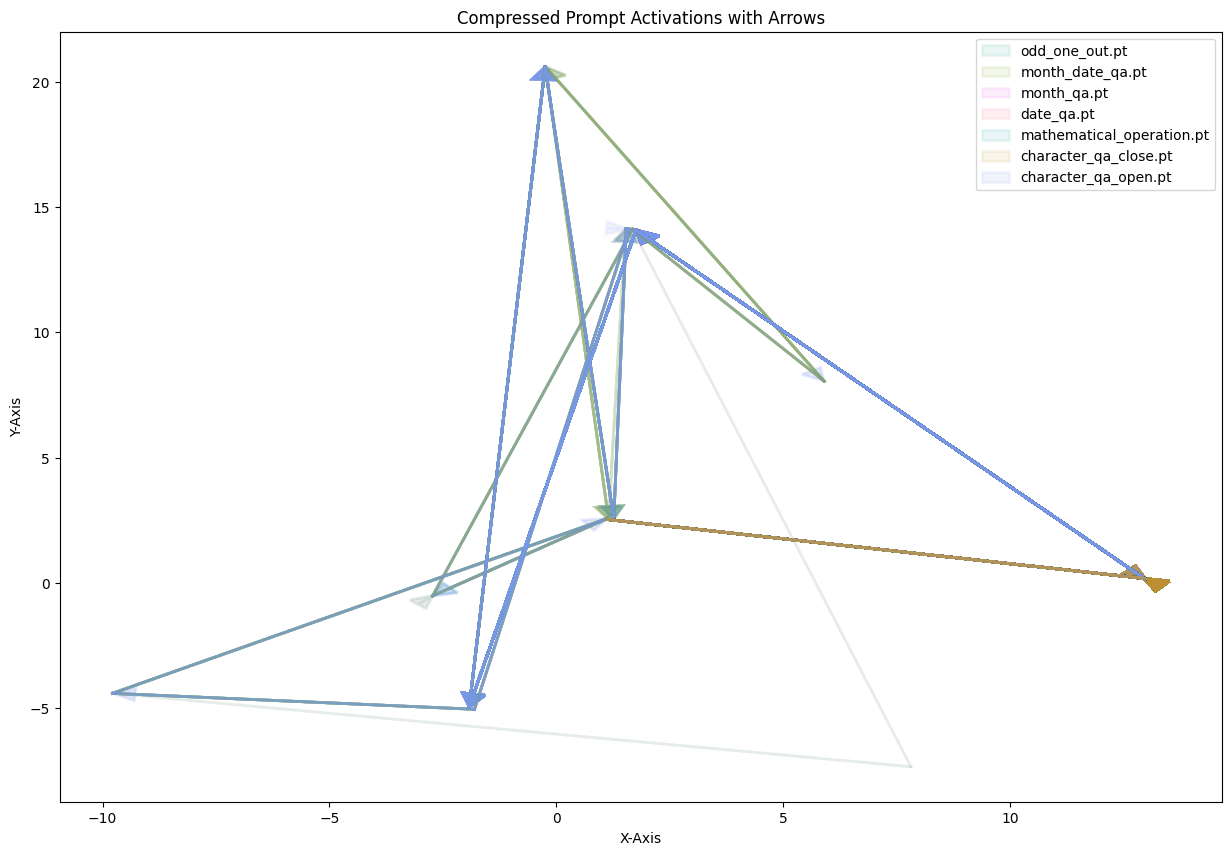

In [12]:
def generate_color_map(unique_elements, alpha=0.1):
    color_palette = sns.color_palette('husl', len(unique_elements))
    color_map = {key: (r, g, b, alpha) for key, (r, g, b) in zip(unique_elements, color_palette)}
    return color_map


unique_filenames = set(all_prompt_filenames)
color_map = generate_color_map(unique_filenames)

# Set the plot size and resolution
plt.figure(figsize=(15, 10), dpi=100)

# Initialize the counters
segment_count = 0
unique_segments = set()

# Draw the arrows with thickness and opacity
for i, (filename, line) in enumerate(zip(all_prompt_filenames, compressed_all_prompt_activations)):
    for j in range(len(line) - 1):
        start_x, start_y = line[j]
        end_x, end_y = line[j+1]
        dx, dy = end_x - start_x, end_y - start_y
        segment_count += 1
        unique_segments.add((filename, (start_x, start_y), (end_x, end_y)))
        if j == len(line) - 2:
            plt.arrow(start_x, start_y, dx, dy, color=color_map[filename], label=filename, length_includes_head=True, head_width=0.5, head_length=0.5, linewidth=2)
        else:
            plt.plot([start_x, end_x], [start_y, end_y], color=color_map[filename], linewidth=2)


# Print the segment counts
print(f"Total segments: {segment_count}")
print(f"Unique segments: {len(unique_segments)}")

plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Compressed Prompt Activations with Arrows')

# Add legend and remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

##3D Visualization

In [13]:
reducer_3d = umap.UMAP(n_components=3, n_neighbors=2)
umap_result_3d = reducer_3d.fit_transform(activations)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [14]:
compressed_all_prompt_activations_3d = []

start_idx=0
for prompt in all_prompt_activations:
  tokens = len(prompt)
  compressed_prompt_3d = umap_result_3d[start_idx:tokens]
  compressed_all_prompt_activations_3d.append(compressed_prompt_3d)

##3D with Matplotlib

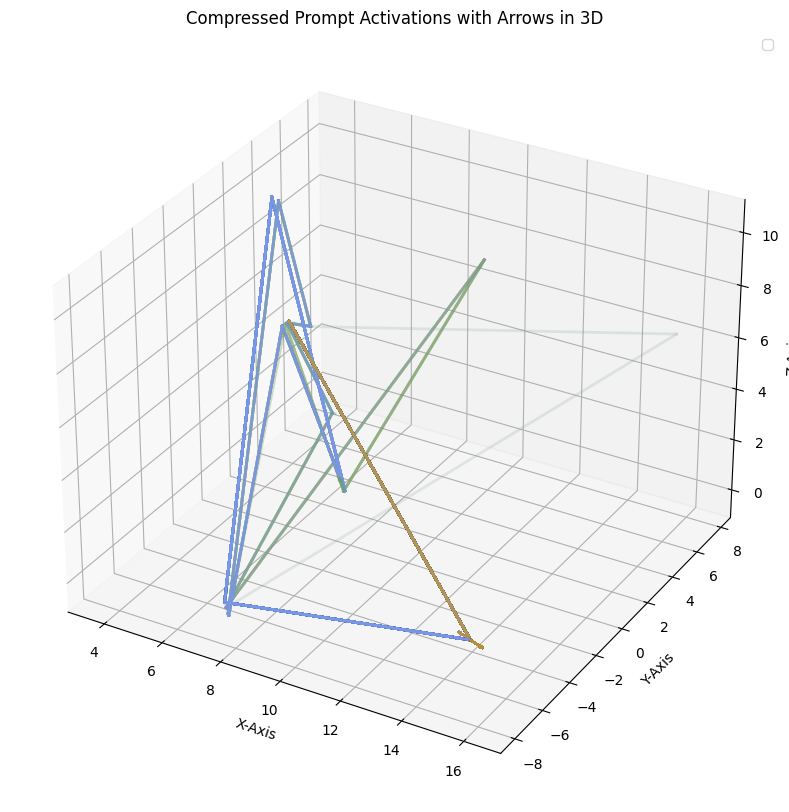

Total segments: 3181
Unique segments: 82


In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import mplcursors

def generate_color_map(unique_elements, alpha=0.1):
    color_palette = sns.color_palette('husl', len(unique_elements))
    color_map = {key: (r, g, b, alpha) for key, (r, g, b) in zip(unique_elements, color_palette)}
    return color_map

unique_filenames = set(all_prompt_filenames)
color_map = generate_color_map(unique_filenames)

# Set the plot size and resolution
fig = plt.figure(figsize=(15, 10), dpi=100)
ax = fig.add_subplot(111, projection='3d')

# Initialize the counters
segment_count = 0
unique_segments = set()

# Draw the arrows with thickness and opacity
for i, (filename, line) in enumerate(zip(all_prompt_filenames, compressed_all_prompt_activations_3d)):
    for j in range(len(line) - 1):
        start_x, start_y, start_z = line[j]
        end_x, end_y, end_z = line[j+1]
        segment_count += 1
        unique_segments.add((filename, (start_x, start_y, start_z), (end_x, end_y, end_z)))
        ax.plot([start_x, end_x], [start_y, end_y], [start_z, end_z], color=color_map[filename], linewidth=2)

        if j == len(line) - 2:
            arrow_length = 0.5
            arrow_dx = (end_x - start_x) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length
            arrow_dy = (end_y - start_y) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length
            arrow_dz = (end_z - start_z) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length

            ax.quiver(start_x, start_y, start_z, arrow_dx, arrow_dy, arrow_dz, color=color_map[filename], length=arrow_length, normalize=True)

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')
plt.title('Compressed Prompt Activations with Arrows in 3D')

# Add legend and remove duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()

# Print the segment counts
print(f"Total segments: {segment_count}")
print(f"Unique segments: {len(unique_segments)}")



##3D with Plotly

In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def generate_color_map(unique_elements, alpha=0.1):
    color_palette = sns.color_palette('husl', len(unique_elements))
    color_map = {key: f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {alpha})' for key, (r, g, b) in zip(unique_elements, color_palette)}
    return color_map

unique_filenames = set(all_prompt_filenames)
color_map = generate_color_map(unique_filenames)

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])

segment_count = 0
unique_segments = set()

for i, (filename, line) in enumerate(zip(all_prompt_filenames, compressed_all_prompt_activations_3d)):
    for j in range(len(line) - 1):
        start_x, start_y, start_z = line[j]
        end_x, end_y, end_z = line[j+1]
        segment_count += 1
        unique_segments.add((filename, (start_x, start_y, start_z), (end_x, end_y, end_z)))
        
        fig.add_trace(go.Scatter3d(
            x=[start_x, end_x], y=[start_y, end_y], z=[start_z, end_z],
            mode='lines',
            line=dict(color=color_map[filename], width=4),
            showlegend=True if j == 0 else False,
            name=filename,
            legendgroup=filename
        ))

        if j == len(line) - 2:
            arrow_length = 0.5
            arrow_dx = (end_x - start_x) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length
            arrow_dy = (end_y - start_y) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length
            arrow_dz = (end_z - start_z) / np.linalg.norm([end_x - start_x, end_y - start_y, end_z - start_z]) * arrow_length

            fig.add_trace(go.Cone(
                x=[end_x - arrow_dx], y=[end_y - arrow_dy], z=[end_z - arrow_dz],
                u=[arrow_dx], v=[arrow_dy], w=[arrow_dz],
                sizemode="scaled",
                sizeref=0.1,
                anchor="tip",
                showscale=False,
                colorscale=[[0, color_map[filename]], [1, color_map[filename]]],
                showlegend=False,
                legendgroup=filename
            ))

fig.update_layout(scene=dict(
    xaxis_title='X-Axis',
    yaxis_title='Y-Axis',
    zaxis_title='Z-Axis'
))
fig.update_layout(title='Compressed Prompt Activations with Arrows in 3D')

fig.show()

# Print the segment counts
print(f"Total segments: {segment_count}")
print(f"Unique segments: {len(unique_segments)}")


Total segments: 3181
Unique segments: 82


###OLD

In [ ]:
d = {'prompt_filenames': all_prompt_filenames, 'prompt_activations': all_prompt_activations}
df = pd.DataFrame(data=d)

In [ ]:
df.head()

,prompt_filenames,prompt_activations
0,character_qa_open.pt,"[0.0003011, -0.0008216, -4.98e-05, 0.001191, 0..."
1,character_qa_open.pt,"[0.0003011, -0.0008216, -4.98e-05, 0.001191, 0..."
2,character_qa_open.pt,"[0.0003011, -0.0008216, -4.98e-05, 0.001191, 0..."
3,character_qa_open.pt,"[0.0003011, -0.0008216, -4.98e-05, 0.001191, 0..."
4,character_qa_open.pt,"[0.0003011, -0.0008216, -4.98e-05, 0.001191, 0..."


In [ ]:
reducer = umap.UMAP()

# Prepare the input for UMAP
activations = np.stack(df['prompt_activations'].to_numpy())

# Apply UMAP to compress dimensions to 2D
reducer = umap.UMAP(n_components=2, n_neighbors=2)
umap_result = reducer.fit_transform(activations)

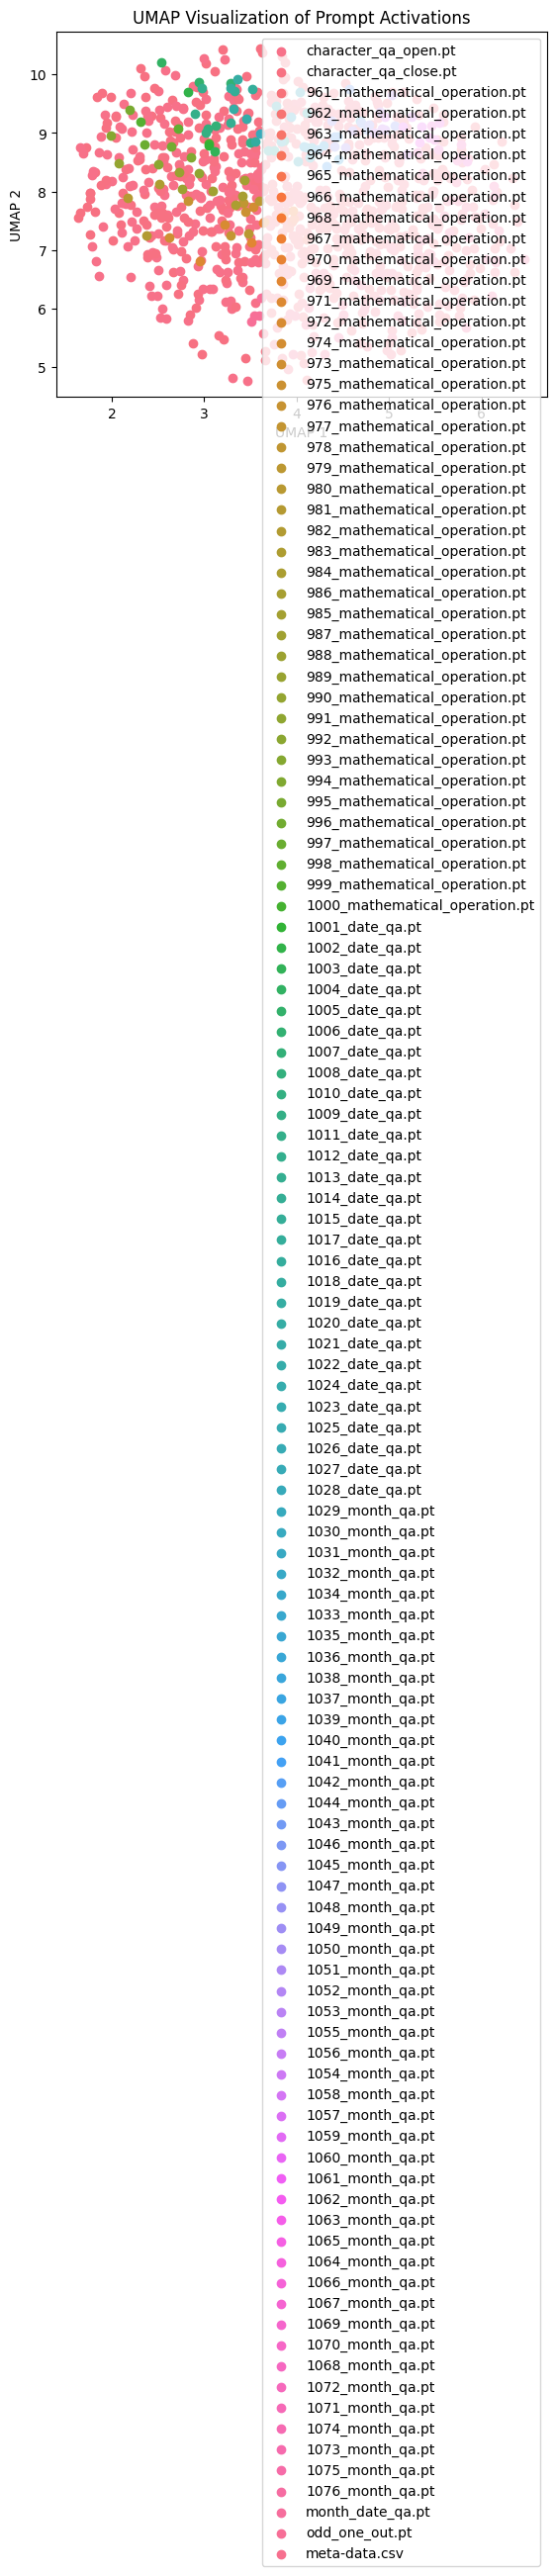

In [ ]:
#Define coloring algo
def generate_color_map(unique_elements):
    color_palette = sns.color_palette('husl', len(unique_elements))
    color_map = {key: color for key, color in zip(unique_elements, color_palette)}
    return color_map

# Create a scatter plot using the reduced dimensions
unique_filenames = df['prompt_filenames'].unique()
color_map = generate_color_map(unique_filenames)

for i, filename in enumerate(df['prompt_filenames']):
    plt.scatter(umap_result[i, 0], umap_result[i, 1], color=color_map[filename], label=filename)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Visualization of Prompt Activations')

# Add legend and remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Save the plot as a PNG file
plt.savefig('umap_visualization.png', dpi=300, bbox_inches='tight')

plt.show()